---
# **Author:** [Ganesh Morye](mailto:ganesh.morye@gmail.com)  
[LinkedIn](https://www.linkedin.com/in/ganeshmorye/) | 
[GitHub](https://github.com/ganeshmorye) |
[Homepage](https://www.ganeshmorye.com/)
---

<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Business Objective** </div>

Predict how many points Lebron James will score in his first regular season game in the 2023-24 season, between the LA Lakers and the Denver Nuggets in Denver on October 24, 2023.


<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Imports** </div>

In [69]:
import os
from pathlib import Path
import glob
import requests
import json
import warnings
from dotenv import load_dotenv

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from joblib import load, dump
import scipy.stats as stats
import time

import plotly.io as pio
pio.renderers.default = 'vscode'




<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Data Collection** </div>

I divided the API calls into two steps:

1. Retrieve Team ID and Player ID: I collected LeBron James' seasonal statistics for the last 10 seasons.
2. Scrape Game by Game Data: Get the schedule data for each of the intended seasons. Using the Schedule, Team ID and Player ID, I collected game by game data for the seasons of interest .

A detailed breakdown of each step is provided below, including the API calls that were made.



## Environment and API Setup

### Files and Folder Locations

In [3]:
# Determine whether it's being run in a Google Colab environment or on a local machine.
# Set up file paths accordingly, so that subsequent code can access files and directories correctly in either environment.
# Print a message to inform the user where the code is being run from.
try:
    from google.colab import drive
    code_dir = Path('/content/drive/My Drive/Colab_Notebooks/caesars_lebron_james_prediction/code')
    data_dir = Path('/content/drive/My Drive/Colab_Notebooks/caesars_lebron_james_prediction/data')
    models_dir = Path('/content/drive/My Drive/Colab_Notebooks/caesars_lebron_james_prediction/models')
    team_data_file = 'lal_team_roster.json'
    profile_data_file = 'lebron_profile_data.json'
    code_in = 'Google Colab'
    drive.mount('/content/drive')
except:
    code_dir = Path('../code')
    data_dir = Path('../data')
    models_dir = Path('../models')
    team_data_file = 'lal_team_roster.json'
    profile_data_file = 'lebron_profile_data.json'
    code_in = 'Local Machine'

print(f'Code is run from {code_in}')

Code is run from Local Machine



### API Key
This project requires an API key. Here's how you can set it up:

1. Obtain an API key from Sportradar.
2. Create a file named `.env` in the root of the project directory.
3. Add the API key to the `.env` file as: `MY_API_KEY=your_actual_api_key`
4. !pip install -q python-dotenv

In [4]:
# path to the .env file
api_file = code_dir / '.env'

# path is converted to a string before passing it to load_dotenv
load_dotenv(dotenv_path=str(api_file))

# API key from environment variable
api_key = os.getenv('MY_API_KEY')

if api_key is None:
    raise ValueError("API key is not set in the environment variables")

### API Calls

Steps to retrieve game data and play-by-play data of LeBron James
- Step 1: Retrieve the Team ID for LA Lakers
- Step 2: Retrieve the Player ID for LeBron James using the Team ID
- Step 3: Retrieve the Player Profile for LeBron James using the Player ID


In [10]:

# Step 1: Retrieve the Team ID for LA Lakers
url_schedule = f'https://api.sportradar.com/nba/trial/v8/en/games/2023/REG/schedule.json?api_key={api_key}'

response_schedule = requests.get(url_schedule)
if response_schedule.status_code == 200:
    schedule_data = response_schedule.json()

    # Locate the team_id for LA Lakers
    for game in schedule_data['games']:
        if 'home' in game and game['home']['name'] == 'Los Angeles Lakers':
            team_id = game['home']['id']
            break
else:
    print(f'Failed to retrieve schedule data: {response_schedule.status_code}')

# Step 2: Retrieve the Player ID for LeBron James using the Team ID
url_team_profile = f'https://api.sportradar.com/nba/trial/v8/en/teams/{team_id}/profile.json?api_key={api_key}'

response_team = requests.get(url_team_profile)
if response_team.status_code == 200:
    team_data = response_team.json()

    # Save team_data to disk
    os.makedirs('data', exist_ok=True)  # Ensure the 'data' directory exists
    save_file = os.path.join(data_dir, team_data_file)
    with open(save_file, 'w') as f:
        json.dump(team_data, f)

    # Locate the player_id for LeBron James
    for player in team_data['players']:
        if player['full_name'] == 'LeBron James':
            player_id = player['id']
            break
else:
    print(f'Failed to retrieve team data: {response_team.status_code}')

# Step 3: Retrieve the Player Profile for LeBron James using the Player ID
url_player_profile = f'https://api.sportradar.com/nba/trial/v8/en/players/{player_id}/profile.json?api_key={api_key}'

response_player = requests.get(url_player_profile)
if response_player.status_code == 200:
    player_data = response_player.json()

    # Save player_data to disk
    save_file = os.path.join(data_dir, profile_data_file)
    with open(save_file, 'w') as f:
        json.dump(player_data, f)
else:
    print(f'Failed to retrieve player data: {response_player.status_code}')


In [5]:

# Load the JSON data into a DataFrame
with open(os.path.join(data_dir, profile_data_file), 'r') as file:
    profile_data = json.load(file)
    lebron_df = pd.json_normalize(profile_data)

# Display the DataFrame
lebron_df.head()

,id,status,full_name,first_name,last_name,abbr_name,height,weight,position,primary_position,...,team.id,team.name,team.market,team.alias,team.sr_id,team.reference,draft.team_id,draft.year,draft.round,draft.pick
0,0afbe608-940a-4d5d-a1f7-468718c67d91,ACT,LeBron James,LeBron,James,L.James,81,250,F,SF,...,583ecae2-fb46-11e1-82cb-f4ce4684ea4c,Lakers,Los Angeles,LAL,sr:team:3427,1610612747,583ec773-fb46-11e1-82cb-f4ce4684ea4c,2003,1,1


In [6]:
# Displaying the LeBron James player profile dataframe
lebron_df.T

,0
id,0afbe608-940a-4d5d-a1f7-468718c67d91
status,ACT
full_name,LeBron James
first_name,LeBron
last_name,James
abbr_name,L.James
height,81
weight,250
position,F
primary_position,SF


## Data Analysis of LeBron James' Profile

### General Observations:
- The DataFrame contains a single row and 33 columns, each providing different pieces of information about LeBron James.
- There are no missing values in the dataset, which is excellent as it means we have a complete dataset for our analysis.
- The dataset provides various details about LeBron James, such as his full name, birthdate, height, weight, position, jersey number, experience, and much more.
- It also contains information about the league and team he is associated with, as well as his draft details.

### Columns Overview:
- **Personal Information**: `full_name`, `first_name`, `last_name`, `height`, `weight`, `birthdate`, `birth_place`, `high_school`.
- **Team and League Information**: `team.id`, `team.name`, `team.market`, `team.alias`, `league.id`, `league.name`, `league.alias`.
- **Player Status and Position**: `status`, `position`, `primary_position`, `jersey_number`, `experience`.
- **Draft Information**: `draft.team_id`, `draft.year`, `draft.round`, `draft.pick`.
- **Additional Identifiers**: `id`, `sr_id`, `reference`, `team.sr_id`, `team.reference`.

### Initial Analysis:
1. **Player Profile**: LeBron James, with a height of 6'9" and weighing 250 lbs, plays in the position of a forward (F) and his primary position is Small Forward (SF). He wears the jersey number 23.

2. **Experience**: LeBron has been playing in the NBA for 20 years, which is derived from the `experience` column.

3. **Team Association**: He is associated with the team "Los Angeles Lakers" which is identified with the team ID `583ecae2-fb46-11e1-82cb-f4ce4684ea4c`.

4. **League Association**: LeBron plays in the NBA, as indicated by the league name and alias columns.

5. **Draft Information**: LeBron was picked in the draft of the year 2003, in the first round as the first pick.

### Conclusions:
The data pertains to the seasonal totals and averages of LeBron's playing career over the last 10 seasons. Since this data does not contain the granularity of game-by-game data, it is not directly relevant for our modeling purposes. However, it provides a general overview of his playing career and serves as a prerequisite step to set up the API URL link to retrieve game-by-game data using the Team and Player ID retrieved in this step.

In [7]:
seasons_data = lebron_df['seasons']

In [8]:
## Seasons column in the player profile dataframe is a nested dictionary which has the total and average performance statistics of LeBron's playing career.
## Converting this nested dictionary to a dataframe

# Initialize an empty list to store the data dictionaries
seasons_data_list = []

# Loop through each season's data and append the dictionary to the list
for season_data in lebron_df['seasons'].iloc[0]:
    # Extracting relevant data from the nested structure
    season_dict = {
        'season_id': season_data['id'],
        'season_year': season_data['year'],
        'season_type': season_data['type'],
    }
    # Extracting team-related data
    team_data = season_data['teams'][0]['total']
    for key, value in team_data.items():
        season_dict[f'total_{key}'] = value

    # Extracting average stats
    average_data = season_data['teams'][0]['average']
    for key, value in average_data.items():
        season_dict[f'avg_{key}'] = value

    # Extracting team name
    team_name = season_data['teams'][0]['name']
    season_dict['team_name'] = team_name

    # Append the dictionary to the list
    seasons_data_list.append(season_dict)

# Convert the list of dictionaries to a DataFrame
seasons_df = pd.DataFrame(seasons_data_list)

# Now, seasons_df contains the extracted data for each season
seasons_df.head(3)

,season_id,season_year,season_type,total_games_played,total_games_started,total_minutes,total_field_goals_made,total_field_goals_att,total_field_goals_pct,total_two_points_made,...,avg_points_in_paint,avg_fouls_drawn,avg_offensive_fouls,avg_fast_break_pts,avg_fast_break_att,avg_fast_break_made,avg_second_chance_pts,avg_second_chance_att,avg_second_chance_made,team_name
0,5027b6ac-731c-4622-8d69-d863ae7c626b,2022,REG,55,54,1954.0,609,1219,0.500,488,...,15.05,4.96,0.49,6.24,3.82,2.51,2.71,2.22,1.13,Lakers
1,16d6292c-25c6-4487-aa90-912c1e09170b,2021,REG,56,56,2084.0,640,1221,0.524,479,...,14.32,5.46,0.32,4.77,3.04,2.11,2.88,2.04,1.13,Lakers
2,feb33381-9dbf-45b6-82c1-3c50c9a2b5ce,2020,REG,45,45,1504.0,422,823,0.513,318,...,11.69,4.58,0.22,4.51,2.44,1.78,2.00,1.22,0.73,Lakers


In [9]:
seasons_df.columns

Index(['season_id', 'season_year', 'season_type', 'total_games_played',
       'total_games_started', 'total_minutes', 'total_field_goals_made',
       'total_field_goals_att', 'total_field_goals_pct',
       'total_two_points_made', 'total_two_points_att', 'total_two_points_pct',
       'total_three_points_made', 'total_three_points_att',
       'total_three_points_pct', 'total_blocked_att', 'total_free_throws_made',
       'total_free_throws_att', 'total_free_throws_pct',
       'total_offensive_rebounds', 'total_defensive_rebounds',
       'total_rebounds', 'total_assists', 'total_turnovers',
       'total_assists_turnover_ratio', 'total_steals', 'total_blocks',
       'total_personal_fouls', 'total_tech_fouls', 'total_points',
       'total_flagrant_fouls', 'total_ejections', 'total_foulouts',
       'total_true_shooting_att', 'total_true_shooting_pct',
       'total_efficiency', 'total_points_off_turnovers',
       'total_points_in_paint', 'total_points_in_paint_made',
       'tot

In [14]:
# Write the DataFrame to a CSV file in the 'data' directory
seasons_df_csv = data_dir / 'lebron_seasons_total_avg_performance_stats.csv'
seasons_df.to_csv(seasons_df_csv, index=False)

## Extracting Historical Game Data for LeBron James Across Previous NBA Seasons

**Step 1: Retrieve Team ID**  
- The code attempts to open and read a JSON file containing team data to extract the team ID for the Los Angeles Lakers (LAL). It handles various potential exceptions, such as file not found or key not present, providing appropriate messages in such cases.

**Step 2: Define the `retrieve_game_data` Function**  
- This function is designed to fetch and store game data for specified NBA seasons from the Sportradar API, focusing on games involving a particular team (LAL in this context). It takes parameters like the API key, team ID, directory for data storage, and a list of seasons for which data is to be retrieved.

**Step 3: Retrieve and Store Game Data**  
- The function iterates through each specified season and retrieves the game schedule, followed by detailed game data for games involving the specified team.
- It checks for existing local data to avoid unnecessary API calls and saves the fetched data as JSON files locally.
- The function respects API rate limits by pausing between API calls.

**Step 4: Execute Data Retrieval**  
- A list of seasons is defined, and the `retrieve_game_data` function is called with appropriate arguments (API key, team ID, data directory, and seasons) to initiate the data retrieval and storage process.


In [10]:
# Retrieving the team_id for the API call
team_data_path = data_dir / team_data_file

# Read the JSON data
try:
    with open(team_data_path, 'r') as file:
        team_data = json.load(file)
        team_id = team_data['id']
        print(f"Team ID for LAL: {team_id}")
except FileNotFoundError:
    print(f"File not found: {team_data_path}")
except KeyError:
    print("Key 'id' not found in the data")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Team ID for LAL: 583ecae2-fb46-11e1-82cb-f4ce4684ea4c


In [47]:

def retrieve_game_data(api_key, team_id, data_dir, seasons):
    """
    Retrieve and save game data for specified seasons and team from the Sportradar API.

    This function iterates through each specified NBA season, retrieves the game schedule,
    and subsequently fetches detailed game data for games involving a specified team.
    The retrieved data is saved locally as JSON files to minimize unnecessary API calls.

    Parameters
    ----------
    api_key : str
        The API key for accessing data from the Sportradar API.
    team_id : str
        The identifier for the team for which game data should be retrieved.
    data_dir : pathlib.Path
        The directory where retrieved data should be saved.
    seasons : list of str
        The NBA seasons (e.g., ['2022', '2023']) for which data should be retrieved.

    Notes
    -----
    - The function checks for existing local data and avoids re-fetching it from the API.
    - To stay within API rate limits, the function pauses for 1.1 seconds after each API call.
    - Game data is saved with filenames in the format: YYYY-MM-DD_opposition_team.json.
    - Schedule data is saved with filenames in the format: schedule_season.json.

    """

    # Loop through each season
    for season in reversed(seasons):
        schedule_file_path = data_dir / f'schedule_{season}.json'

        # Check if schedule data already exists
        if not schedule_file_path.exists():
            # Retrieve the season schedule
            url_schedule = f'https://api.sportradar.com/nba/trial/v8/en/games/{season}/REG/schedule.json?api_key={api_key}'
            response_schedule = requests.get(url_schedule)
            if response_schedule.status_code == 200:
                schedule_data = response_schedule.json()
                # Save the schedule data
                with open(schedule_file_path, 'w') as f:
                    json.dump(schedule_data, f)
            # Pause to stay within API rate limits
            time.sleep(1.1)
        else:
            # Load existing schedule data
            with open(schedule_file_path, 'r') as f:
                schedule_data = json.load(f)

        # Loop through each game in the schedule
        for game in schedule_data['games']:
            # Check if LAL is playing
            if game['home']['id'] == team_id or game['away']['id'] == team_id:
                game_id = game['id']
                scheduled_date = game['scheduled'][:10]  # Extracting date (YYYY-MM-DD) from the timestamp
                opposition_team = game['home']['name'] if game['home']['id'] != team_id else game['away']['name']
                game_file_path = data_dir / f'{scheduled_date}_{opposition_team}.json'

                # Check if game data already exists
                if not game_file_path.exists():
                    # Retrieve the game summary
                    url_game_summary = f'https://api.sportradar.com/nba/trial/v8/en/games/{game_id}/summary.json?api_key={api_key}'
                    response_game = requests.get(url_game_summary)
                    if response_game.status_code == 200:
                        game_data = response_game.json()
                        # Save the game data
                        with open(game_file_path, 'w') as f:
                            json.dump(game_data, f)
                    # Pause to stay within API rate limits
                    time.sleep(1.1)





In [62]:

# Define the seasons to retrieve data for
seasons = ['2018', '2019', '2020', '2021', '2022']


retrieve_game_data(api_key, team_id, data_dir, seasons)



### Focusing Analysis on LeBron's Lakers Tenure: A Rationale

In this modeling exercise, I focus only on games played by LeBron since his move to Lakers.

#### 1. **Team Dynamics and Strategy Variation:**

- Moving to the Lakers from the Cavaliers means a change in team dynamics, strategies, and roles which can significantly impact LeBron's performance and statistics.
     
- Different coaches and team strategies between the Cavaliers and Lakers might utilize LeBron’s skills in varied ways, impacting his game statistics differently.

#### 2. **Relevance and Timeliness of Data:**

- Athletes' performance can change due to factors like age, fitness, and injury. Focusing on recent data (Lakers period) might provide a more accurate representation of LeBron's current form and playing style.

- The most recent data is often the most relevant when making future predictions, ensuring that the model is based on his current playing conditions and team dynamics.

#### 3. **Consistency in Data:**

- Using data from his time with the Lakers ensures a level of consistency in the external factors, such as team strategy, coaching style, and teammate dynamics, which might influence his performance.

- Introducing data from different teams and periods might introduce noise and variability into the model due to the different playing conditions and contexts.

#### 4. **Model Simplicity and Interpretability:**

- Focusing on a specific period or team reduces the complexity of the model by not having to account for additional variables and changes from different teams or eras.

- Models built on more consistent and specific data tend to be easier to interpret and explain, especially when considering feature importance and predictions.

#### 5. **Prediction Specificity:**

- Since the predictions are intended for a future game involving the Lakers, using data specific to LeBron’s time in this team is contextually relevant and likely to be more accurate.

- Players may adapt and change their playing style over time. LeBron’s style and role within the Lakers might be different compared to his time with the Cavaliers, making the Lakers' data more relevant for predictions during this period.

### **Conclusion**:
Opting to utilize data from LeBron's tenure with the Lakers aims to ensure relevance, consistency, and accuracy in the predictive model, providing a robust basis for future performance predictions.


### Decision on Data Granularity for Modeling

The game data provides both overall and quarter-by-quarter statistics for players, home team, and away team. For modeling purposes, I will focus exclusively on the overall game statistics, excluding the quarter-by-quarter data. Since our primary objective is to predict the total points scored in a particular game, I believe that the overall statistics should suffice for accurate predictions.


### Pros of Excluding Quarter-by-Quarter Statistics:
1. **Simplicity**: The model will be simpler and will require less computational resources and data.
2. **Avoiding Overfitting**: With fewer variables, the model might be less prone to overfitting, especially since I have a limited amount of data.
3. **Generalization**: The model might generalize better to new data since it's not being influenced by the potentially noisy quarter-by-quarter data.



In [12]:
def extract_lebron_and_team_performance_data(game_data):
    """
    Extract LeBron James' performance data, team statistics for LAL and opponent teams, and additional context from game_data JSON.

    Parameters:
        game_data (dict): The JSON data of a game.

    Returns:
        dict: A dictionary containing LeBron's performance data, team statistics, and additional context.
    """
    # Initialize a dictionary to store the extracted data
    extracted_data = {}

    # Determine if Lakers are home or away
    lakers_are_home = game_data['home']['name'] == 'Lakers'

    # Extract Opponent Team Data
    extracted_data['opponent_team_name'] = game_data['away']['name'] if lakers_are_home else game_data['home']['name']
    extracted_data['opponent_team_alias'] = game_data['away']['alias'] if lakers_are_home else game_data['home']['alias']

    # Extract Team Context
    extracted_data['lakers_score'] = game_data['home']['points'] if lakers_are_home else game_data['away']['points']
    extracted_data['opponent_score'] = game_data['away']['points'] if lakers_are_home else game_data['home']['points']

    # Extract Game Context
    extracted_data['game_location'] = 'home' if lakers_are_home else 'away'

    # Extract Seasonal and Monthly Trends
    extracted_data['game_date'] = game_data['scheduled']

    # Extract LeBron James' performance data
    for team_type in ['home', 'away']:
        for player in game_data[team_type]['players']:
            if player['full_name'] == 'LeBron James':
                # Extract all statistics excluding quarter-by-quarter data
                for stat_key, stat_value in player['statistics'].items():
                    # Exclude quarter-by-quarter data
                    if stat_key != 'periods':
                        extracted_data[f'lebron_{stat_key}'] = stat_value
                break

    # Extract team statistics for LAL and opponent teams
    for team_type in ['home', 'away']:
        prefix = 'lal_' if (team_type == 'home' and lakers_are_home) or (team_type == 'away' and not lakers_are_home) else 'opponent_'
        for stat_key, stat_value in game_data[team_type]['statistics'].items():
            # Exclude quarter-by-quarter data
            if stat_key not in ['periods', 'most_unanswered']:
                extracted_data[f'{prefix}team_{stat_key}'] = stat_value

    return extracted_data


In [13]:

# Initialize an empty list to store the extracted data
all_extracted_data = []

# Loop through each JSON file in the data directory
for game_file_path in glob.glob(str(data_dir / '[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]*.json')):
    # Load the JSON data
    with open(game_file_path, 'r') as file:
        game_data = json.load(file)

    # Check if the game status is 'closed'
    if game_data['status'] == 'closed':
        # Call the function to extract data
        extracted_data = extract_lebron_and_team_performance_data(game_data)

        # Append the extracted data to the list
        all_extracted_data.append(extracted_data)
    else:
        print(f"Skipping {game_file_path} as the game status is not 'closed'.")

# Convert the list of extracted data into a DataFrame
lebron_and_team_stats_df = pd.DataFrame(all_extracted_data)

# Write the DataFrame to a CSV file in the 'data' directory
lebron_and_team_stats_csv = data_dir / 'lebron_and_team_stats.csv'


Skipping ../data/2020-04-13_Minnesota Timberwolves.json as the game status is not 'closed'.
Skipping ../data/2020-03-13_Houston Rockets.json as the game status is not 'closed'.
Skipping ../data/2020-04-08_Golden State Warriors.json as the game status is not 'closed'.
Skipping ../data/2020-03-31_Minnesota Timberwolves.json as the game status is not 'closed'.
Skipping ../data/2020-03-16_Denver Nuggets.json as the game status is not 'closed'.
Skipping ../data/2020-04-16_Phoenix Suns.json as the game status is not 'closed'.
Skipping ../data/2020-03-19_Utah Jazz.json as the game status is not 'closed'.
Skipping ../data/2020-04-02_Indiana Pacers.json as the game status is not 'closed'.
Skipping ../data/2020-04-05_Sacramento Kings.json as the game status is not 'closed'.
Skipping ../data/2020-03-22_Detroit Pistons.json as the game status is not 'closed'.
Skipping ../data/2020-04-09_Chicago Bulls.json as the game status is not 'closed'.
Skipping ../data/2020-03-26_Cleveland Cavaliers.json as t

In [ ]:
lebron_and_team_stats_df.to_csv(lebron_and_team_stats_csv, index=False)

<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Exploratory Data Analysis** </div>

**LeBron James Seasonal Performance Statistics EDA**

In [14]:

# Define a color map for team names
team_color_map = {
    'Lakers': '#4F6294',
    'Cavaliers': '#DAA520',
    'Heat': '#B22222',
}

# Creating the 1st dashboard of total statistics
fig_total = sp.make_subplots(rows=2, cols=3, subplot_titles=('Total Games Played', 'Total Minutes', 
                                                             'Total Rebounds', 'Total Assists', 
                                                             'Total Points', 'Total Efficiency'),
                            vertical_spacing=0.1)


for team, color in team_color_map.items():
    # Filter data for the current team
    team_data = seasons_df[seasons_df['team_name'] == team]

    # Total Games Played
    fig_total.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['total_games_played'], name=team, marker_color=color, legendgroup=team, showlegend=True),
        row=1, col=1
    )

    # Other traces with `showlegend=False` to avoid multiple legend entries
    fig_total.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['total_minutes'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=1, col=2
    )

    fig_total.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['total_rebounds'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=1, col=3
    )

    fig_total.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['total_assists'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=2, col=1
    )

    fig_total.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['total_points'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=2, col=2
    )

    fig_total.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['total_efficiency'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=2, col=3
    )

# Update layout
fig_total.update_layout(
    title='LeBron James Career Overview: Total Statistics',
    height=800,
    width=1200,
    barmode='group',
    legend_title_text='Team',
    xaxis1=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis2=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis3=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis4=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis5=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis6=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45)
)

# Add annotations for championships and MVP awards
championship_years = [2013, 2016, 2020]
mvp_years = [2013]

for year in championship_years:
    fig_total.add_annotation(
        x=year, y=seasons_df.loc[seasons_df['season_year'] == year, 'total_games_played'].max() + 4,
        text="🏆", showarrow=False, font=dict(size=14, color="Gold")
    )

for year in mvp_years:
    fig_total.add_annotation(
        x=year, y=seasons_df.loc[seasons_df['season_year'] == year, 'total_games_played'].max() + 10,
        text="MVP", showarrow=False, font=dict(size=14, color="Red")
    )
fig_total.show()





**[Click Here to View the Total Statistics Dashboard](../code/dashboard/Total_Statistics.html)**

Note: You may be required to click the `Trust HTML` at the top right corner of the tab

In [15]:
# Creating the 2nd dashboard of average statistics
fig_avg = sp.make_subplots(rows=2, cols=2, subplot_titles=('Average Rebounds', 'Average Assists', 
                                                           'Average Points', 'Average Efficiency'),
                          vertical_spacing=0.1)

for team, color in team_color_map.items():
    # Filter data for the current team
    team_data = seasons_df[seasons_df['team_name'] == team]

    # Average Rebounds
    fig_avg.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['avg_rebounds'], name=team, marker_color=color, legendgroup=team, showlegend=True),
        row=1, col=1
    )

    # Average Assists
    fig_avg.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['avg_assists'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=1, col=2
    )

    # Average Points
    fig_avg.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['avg_points'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=2, col=1
    )

    # Average Efficiency
    fig_avg.add_trace(
        go.Bar(x=team_data['season_year'], y=team_data['avg_efficiency'], name=team, marker_color=color, legendgroup=team, showlegend=False),
        row=2, col=2
    )

# Update layout
fig_avg.update_layout(
    title='LeBron James Career Overview: Average Statistics',
    height=800,
    width=1000,
    barmode='group',
    xaxis1=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis2=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis3=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45),
    xaxis4=dict(tickmode='array', tickvals=seasons_df['season_year'], ticktext=seasons_df['season_year'], tickangle=-45)

)

for year in championship_years:
    fig_avg.add_annotation(
        x=year, y=seasons_df.loc[seasons_df['season_year'] == year, 'avg_rebounds'].max() + 0.5,
        text="🏆", showarrow=False, font=dict(size=14, color="Gold")
    )

for year in mvp_years:
    fig_avg.add_annotation(
        x=year, y=seasons_df.loc[seasons_df['season_year'] == year, 'avg_rebounds'].max() + 1.5,
        text="MVP", showarrow=False, font=dict(size=14, color="Red")
    )

fig_avg.show()

**[Click Here to View the Average Statistics Dashboard](../code/dashboard/Average_Statistics.html)**

Note: You may be required to click the `Trust HTML` at the top right corner of the tab

### Observations

**1st Dashboard: Total Statistics**

- **Total Games Played**: LeBron has played a lot of games every season, which shows how durable and reliable he is. There are a few seasons where he played fewer games, maybe because of injuries, the lockout, or to rest him (load management).

- **Total Minutes**: The total minutes LeBron plays each season show how important he is to his teams. He can play a lot of minutes without getting hurt, which is amazing and shows how good his physical conditioning is. But it's important to manage his minutes so he doesn't burn out and can play for a long time.

- **Total Rebounds**: LeBron has always been a good rebounder, which is important for starting fast breaks, which is a big part of his game. His rebounding ability also shows how versatile he is and how he can affect different parts of the game.

- **Total Assists**: LeBron's assist totals show that he's both a scorer and a passer. His court vision and basketball IQ let him create scoring opportunities for his teammates, which makes the team better and more versatile on offense.

- **Total Points**: LeBron has scored a lot of points consistently. He can score in a lot of ways—driving to the basket, shooting jumpers, and making free throws—which makes him a threat to score from anywhere on the court. His scoring doesn't drop off much from season to season, which shows that he produces consistently on offense.

- **Total Efficiency**: Efficiency can include scoring, passing, and defense. A consistent efficiency shows that LeBron has been able to keep his performance balanced, contributing in scoring, facilitating, and defending, which is important for his teams' success.

**2nd Dashboard: Average Statistics**

- **Average Rebounds**: LeBron's rebounding averages have been steady, with some small changes. His ability to get rebounds is important for his teams on defense and for creating more offensive opportunities through offensive boards.

- **Average Assists**: His assist averages show how good he is at passing. Seasons with higher assist averages might show that he was playing a more facilitative role, while lower averages might show that he was focusing on scoring or playing with more ball-dominant teammates.

- **Average Points**: LeBron's scoring averages have been very consistent, with some seasons showing higher averages, which might show that he was playing a more scoring-focused role during those times. His ability to keep his scoring average steady is important for his teams' offensive schemes.

- **Average Efficiency**: Looking at average efficiency, maintaining a high-efficiency level shows LeBron's ability to contribute positively to the game while minimizing negative impacts (like turnovers). Seasons with particularly high efficiency might show that he was playing at his peak.

These insights give us a glimpse into LeBron's career, showcasing his versatility, consistency, and ability to affect different parts of the game. His career has been marked by reliable performance, adaptability, and the ability to contribute significantly in scoring, playmaking, and rebounding, which is reflected in these dashboards.

**LeBron James Lakers Career EDA**

In [31]:

# Custom date parser function
def custom_date_parser(x):
    """
    Convert a string representation of a date and time into a Python date object.

    This function takes a string in the format "YYYY-mm-ddTHH:MM:SS%z" and converts it
    into a Python date object, effectively extracting the date and discarding the time
    and timezone information.

    Parameters
    ----------
    x : str
        A string representing a date and time, expected to be in the
        format "YYYY-mm-ddTHH:MM:SS%z".

    Returns
    -------
    datetime.date
        A Python date object corresponding to the date information extracted
        from the input string.

    Notes
    -----
    - The function expects the input string to be properly formatted. Malformed strings
      will raise a ValueError.
    - The function discards time and timezone information, returning only the date.
    """
    return datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z").date()

lebron_and_team_stats_csv = data_dir / 'lebron_and_team_stats.csv'

# 'game_date' is the column name that contains the date strings
lebron_and_team_stats_df = pd.read_csv(lebron_and_team_stats_csv, parse_dates=['game_date'], date_parser=custom_date_parser)


/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_99764/2630407248.py:33: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [32]:
# Display the DataFrame
lebron_and_team_stats_df.head(3)

,opponent_team_name,opponent_team_alias,lakers_score,opponent_score,game_location,game_date,lebron_minutes,lebron_field_goals_made,lebron_field_goals_att,lebron_field_goals_pct,...,lal_team_defensive_points_per_possession,lal_team_offensive_points_per_possession,lal_team_team_fouls,lal_team_total_fouls,lal_team_second_chance_att,lal_team_second_chance_made,lal_team_second_chance_pct,lal_team_fast_break_att,lal_team_fast_break_made,lal_team_fast_break_pct
0,Warriors,GSW,109,123,away,2022-10-19,35:12,12,26,46.2,...,1.04,0.92,0,18,11,2,18.2,18,11,61.1
1,Clippers,LAC,97,103,home,2022-10-21,36:40,7,17,41.2,...,0.96,0.90,0,24,8,3,37.5,13,6,46.2
2,Trail Blazers,POR,104,106,home,2022-10-23,37:43,12,22,54.5,...,1.02,1.00,0,24,9,4,44.4,19,8,42.1


In [33]:
lebron_and_team_stats_df.columns

Index(['opponent_team_name', 'opponent_team_alias', 'lakers_score',
       'opponent_score', 'game_location', 'game_date', 'lebron_minutes',
       'lebron_field_goals_made', 'lebron_field_goals_att',
       'lebron_field_goals_pct',
       ...
       'lal_team_defensive_points_per_possession',
       'lal_team_offensive_points_per_possession', 'lal_team_team_fouls',
       'lal_team_total_fouls', 'lal_team_second_chance_att',
       'lal_team_second_chance_made', 'lal_team_second_chance_pct',
       'lal_team_fast_break_att', 'lal_team_fast_break_made',
       'lal_team_fast_break_pct'],
      dtype='object', length=206)

## Analysis of LeBron James' Performance Dataset

### 1. LeBron's Performance Statistics
LeBron's performance statistics focus on his individual contributions, skills, and impact during a game. Understanding these metrics can provide insights into his playing style, consistency, and how his performance might influence the outcome of a game.

#### Sub-Categories and Significance:

##### - Scoring Metrics:
  - **Includes:** Field goals made/attempted/percentage, three-point and two-point shots made/attempted/percentage, free throws made/attempted/percentage, and total points.
  - **Significance:** Helps to understand LeBron's scoring ability and efficiency, which is crucial for predicting his point totals.
   
##### - Playmaking Metrics:
  - **Includes:** Assists and assists to turnover ratio.
  - **Significance:** Indicates LeBron's ability to create scoring opportunities for teammates, which can influence overall team performance and potentially his own scoring opportunities.
   
##### - Defensive Metrics:
  - **Includes:** Defensive rebounds, steals, and blocks.
  - **Significance:** Provides insights into LeBron's defensive contributions, which can impact the opponent’s scoring and the overall game flow.
   
##### - Efficiency and Impact Metrics:
  - **Includes:** Effective field goal percentage, true shooting percentage, plus/minus, and efficiency.
  - **Significance:** Helps to evaluate how effectively LeBron utilizes his scoring opportunities and his overall impact on the game.

##### - Physical and Effort Metrics:
  - **Includes:** Offensive and defensive rebound percentages, steals percentage, and turnovers percentage.
  - **Significance:** Offers insights into LeBron's physicality, effort, and how these aspects might correlate with his and the team’s performance.

### 2. Team Performance Statistics
Team performance statistics provide a holistic view of how the entire team (Lakers and Opponent) performs during a game. These metrics can help to understand the context in which LeBron is playing and how team dynamics might influence his performance.

#### Sub-Categories and Significance:

##### - Team Scoring Metrics:
  - **Includes:** Team field goals made/attempted/percentage, three-point and two-point shots made/attempted/percentage, and total points.
  - **Significance:** Helps to understand the scoring ability and efficiency of the teams, which can influence the game's pace and LeBron’s scoring opportunities.
   
##### - Team Defensive Metrics:
  - **Includes:** Opponent team field goals made/attempted/percentage, steals, and blocks.
  - **Significance:** Provides insights into the defensive capabilities of the teams, which can impact the scoring environment and potentially LeBron’s scoring.

##### - Team Playmaking and Ball Handling Metrics:
  - **Includes:** Total assists, turnovers, and assists to turnover ratio.
  - **Significance:** Indicates the team's ball-handling and playmaking capabilities, which can influence overall team performance and scoring opportunities.

##### - Team Effort Metrics:
  - **Includes:** Total rebounds, offensive and defensive rebounds, and second-chance points.
  - **Significance:** Provides insights into the team's effort levels, which can impact possession dynamics and provide additional scoring opportunities.

##### - Team Discipline and Control Metrics:
  - **Includes:** Personal fouls, technical fouls, and ejections.
  - **Significance:** Helps to understand the team's discipline and how it might impact player availability and game flow.

### Significance to Modeling Process:
- **Understanding Correlations:** Identifying how LeBron’s performance metrics correlate with his scoring can help to select relevant features for the model.
- **Contextualizing Performance:** Team metrics provide context to LeBron’s performance, helping to understand how team dynamics might influence his scoring.
- **Identifying Patterns:** Exploring data can help to identify patterns/trends in LeBron’s scoring relative to his own performance and team dynamics.
- **Model Robustness:** Including a diverse set of features can help to build a more robust model by capturing various aspects that might influence LeBron’s scoring.
- **Validation and Improvement:** Understanding the data helps in validating model predictions and identifying areas for model improvement.


In [34]:
# Analyzing missed games each season

# 1. Extract Season
lebron_and_team_stats_df['season'] = lebron_and_team_stats_df['game_date'].apply(
    lambda x: f"{x.year}-{x.year + 1}" if x.month >= 10 else f"{x.year - 1}-{x.year}"
)


# 2. Count Games
total_games_per_season = lebron_and_team_stats_df.groupby('season').size()
total_games = len(lebron_and_team_stats_df)

# 3. Count Missed Games
missed_games_per_season = lebron_and_team_stats_df[lebron_and_team_stats_df['lebron_minutes'] == '00:00'].groupby('season').size()
missed_games = len(lebron_and_team_stats_df[lebron_and_team_stats_df['lebron_minutes'] == '00:00'])

# 4. Calculate Percentages
missed_percentage_per_season = round(((missed_games_per_season / total_games_per_season) * 100),0)
missed_percentage_total = (missed_games / total_games) * 100

# Creating a DataFrame
missed_games_df = pd.DataFrame({
    'Season': missed_games_per_season.index,
    'Total Games': total_games_per_season[missed_games_per_season.index].values,  # Added this line
    'Missed Games': missed_games_per_season.values,
    'Missed Games Percentage': missed_percentage_per_season.values
})

# Displaying the results
print(f"Total missed games: {missed_games}")
print(f"Total missed games percentage: {missed_percentage_total:.2f}%")
missed_games_df


Total missed games: 111
Total missed games percentage: 28.53%


,Season,Total Games,Missed Games,Missed Games Percentage
0,2018-2019,82,27,33.0
1,2019-2020,71,4,6.0
2,2020-2021,72,27,38.0
3,2021-2022,82,26,32.0
4,2022-2023,82,27,33.0


In [35]:

# Convert 'minutes' to integer total minutes played and filter out games where LeBron did not play
lebron_and_team_stats_df = lebron_and_team_stats_df[lebron_and_team_stats_df['lebron_minutes'].apply(lambda x: int(x.split(':')[0])) > 0]



In [36]:
lebron_and_team_stats_df.describe().T

,count,mean,min,25%,50%,75%,max,std
lakers_score,278.0,114.183453,85.0,106.0,114.0,122.0,143.0,11.64667
opponent_score,278.0,112.068345,80.0,104.25,112.0,119.0,143.0,12.208138
game_date,278,2020-12-31 08:17:15.971223040,2018-10-19 00:00:00,2019-11-23 06:00:00,2021-01-25 00:00:00,2022-02-23 18:00:00,2023-04-09 00:00:00,NaN
lebron_field_goals_made,278.0,10.330935,3.0,8.0,10.0,13.0,19.0,3.039781
lebron_field_goals_att,278.0,20.363309,6.0,18.0,20.0,23.0,31.0,4.326188
...,...,...,...,...,...,...,...,...
lal_team_second_chance_made,278.0,5.143885,0.0,4.0,5.0,6.0,12.0,2.225747
lal_team_second_chance_pct,278.0,52.660791,0.0,41.325,53.8,64.125,100.0,16.852863
lal_team_fast_break_att,278.0,11.543165,2.0,9.0,11.0,14.0,25.0,4.069337
lal_team_fast_break_made,278.0,7.151079,1.0,5.0,7.0,9.0,17.0,2.876303


### Observations on LeBron James' Lakers Career

#### General Overview

LeBron James, widely regarded as one of the greatest basketball players in the NBA, has showcased a stellar performance throughout his career. The descriptive statistics of his game data provide a quantitative overview of his consistency and dominance in various aspects of the game. Let's delve into some of the key statistics to understand his impact on the court.

#### Scoring

- **Points**: LeBron has an average of approximately 27.39 points per game, with a standard deviation of 7.55, indicating a consistent scoring pattern. His maximum points in a game have reached an impressive 56, showcasing his capability to undertake high-scoring games.

- **Field Goals (FG)**: With an average of 10.33 FG made per game and attempting around 20.36, he has a FG percentage of about 50.56%. His scoring is not only prolific but also efficient.

- **Three-Point Shooting**: LeBron makes about 2.32 three-pointers per game on 6.70 attempts, with a shooting percentage of approximately 32.60%. Though not primarily a three-point shooter, he provides a decent threat from beyond the arc.

- **Free Throws**: He has a free-throw percentage of around 70.07%, indicating there's room for improvement in capitalizing on free-throw opportunities.

#### Playmaking

- **Assists**: Averaging around 7.96 assists per game, LeBron demonstrates his playmaking abilities, ensuring his teammates are involved in the offensive setup.

- **Turnovers**: With an average of 3.60, managing turnovers might enhance the team's offensive efficiency.

#### Defensive Contributions

- **Rebounds**: LeBron contributes significantly to the boards, with an average of 8.10 rebounds per game, of which 7.09 are defensive rebounds.

- **Steals and Blocks**: Averaging 1.15 steals and 0.67 blocks per game, LeBron provides a defensive presence, though these stats suggest he's more of a team defender than an individual stopper.

#### Efficiency

- **Efficiency Rating**: An average efficiency rating of 32.44 and an efficiency game score of 22.28 highlight his overall impact on the game, balancing scoring, playmaking, and defense.

#### In-Game Impact

- **Plus/Minus**: The average plus/minus rating of 3.38 indicates that teams LeBron has played for tend to outscore opponents when he's on the floor.

#### Observational Summary

LeBron James exhibits a well-rounded game, contributing significantly in scoring, playmaking, and defensive aspects. His ability to score efficiently, facilitate teammates, and impact games positively is evident from the descriptive statistics. However, aspects like free-throw shooting and managing turnovers present areas for potential enhancement. His overall impact, consistency, and ability to perform in crucial moments have been pivotal throughout his illustrious career.

### Data Quality Check

- Missing values
- Categorial and Numerical columns
- Data Type Conversions
- Correlations

In [37]:
# Missing Values Analysis
missing_values = lebron_and_team_stats_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

opponent_team_total_turnovers    220
lal_team_total_turnovers         220
dtype: int64

In [38]:
# Categorical Features Analysis
categorical_features = lebron_and_team_stats_df.select_dtypes(include=['object'])
unique_values_in_categorical = categorical_features.nunique().sort_values(ascending=False)
unique_values_in_categorical

lal_team_time_leading         252
opponent_team_time_leading    251
lebron_minutes                230
opponent_team_name             29
opponent_team_alias            29
season                          5
opponent_team_minutes           4
lal_team_minutes                4
game_location                   2
dtype: int64

In [39]:
# Converting Time Features to Numeric Format

def convert_time_to_minutes(time_str):
    """
    Converts a time string in the format 'hours:minutes:seconds' or 'minutes:seconds'
    to a float representing total minutes.
    """
    try:
        time_parts = list(map(int, time_str.split(':')))
        if len(time_parts) == 3:  # Format is 'hours:minutes:seconds'
            hours, minutes, seconds = time_parts
        elif len(time_parts) == 2:  # Format is 'minutes:seconds'
            hours = 0
            minutes, seconds = time_parts
        else:
            return None  # Handling unexpected formats
        return (hours * 60) + minutes + (seconds / 60)
    except ValueError:  # handling missing or malformed strings
        return None




In [40]:
# Applying the conversion to the specified columns
time_columns = ['lal_team_time_leading', 'opponent_team_time_leading', 'lebron_minutes', 'lal_team_minutes', 'opponent_team_minutes' ]
lebron_and_team_stats_df[time_columns] = lebron_and_team_stats_df[time_columns].map(convert_time_to_minutes)

# Checking the conversion
lebron_and_team_stats_df[time_columns].head()

,lal_team_time_leading,opponent_team_time_leading,lebron_minutes,lal_team_minutes,opponent_team_minutes
0,0.633333,43.183333,35.200000,240.0,240.0
1,4.083333,38.950000,36.666667,240.0,240.0
2,21.383333,23.316667,37.716667,240.0,240.0
3,1.800000,42.216667,35.300000,240.0,240.0
4,2.733333,43.400000,37.450000,240.0,240.0


In [41]:
# Categorical Features Analysis
categorical_features = lebron_and_team_stats_df.select_dtypes(include=['object'])
unique_values_in_categorical = categorical_features.nunique().sort_values(ascending=False)
unique_values_in_categorical

opponent_team_name     29
opponent_team_alias    29
season                  5
game_location           2
dtype: int64

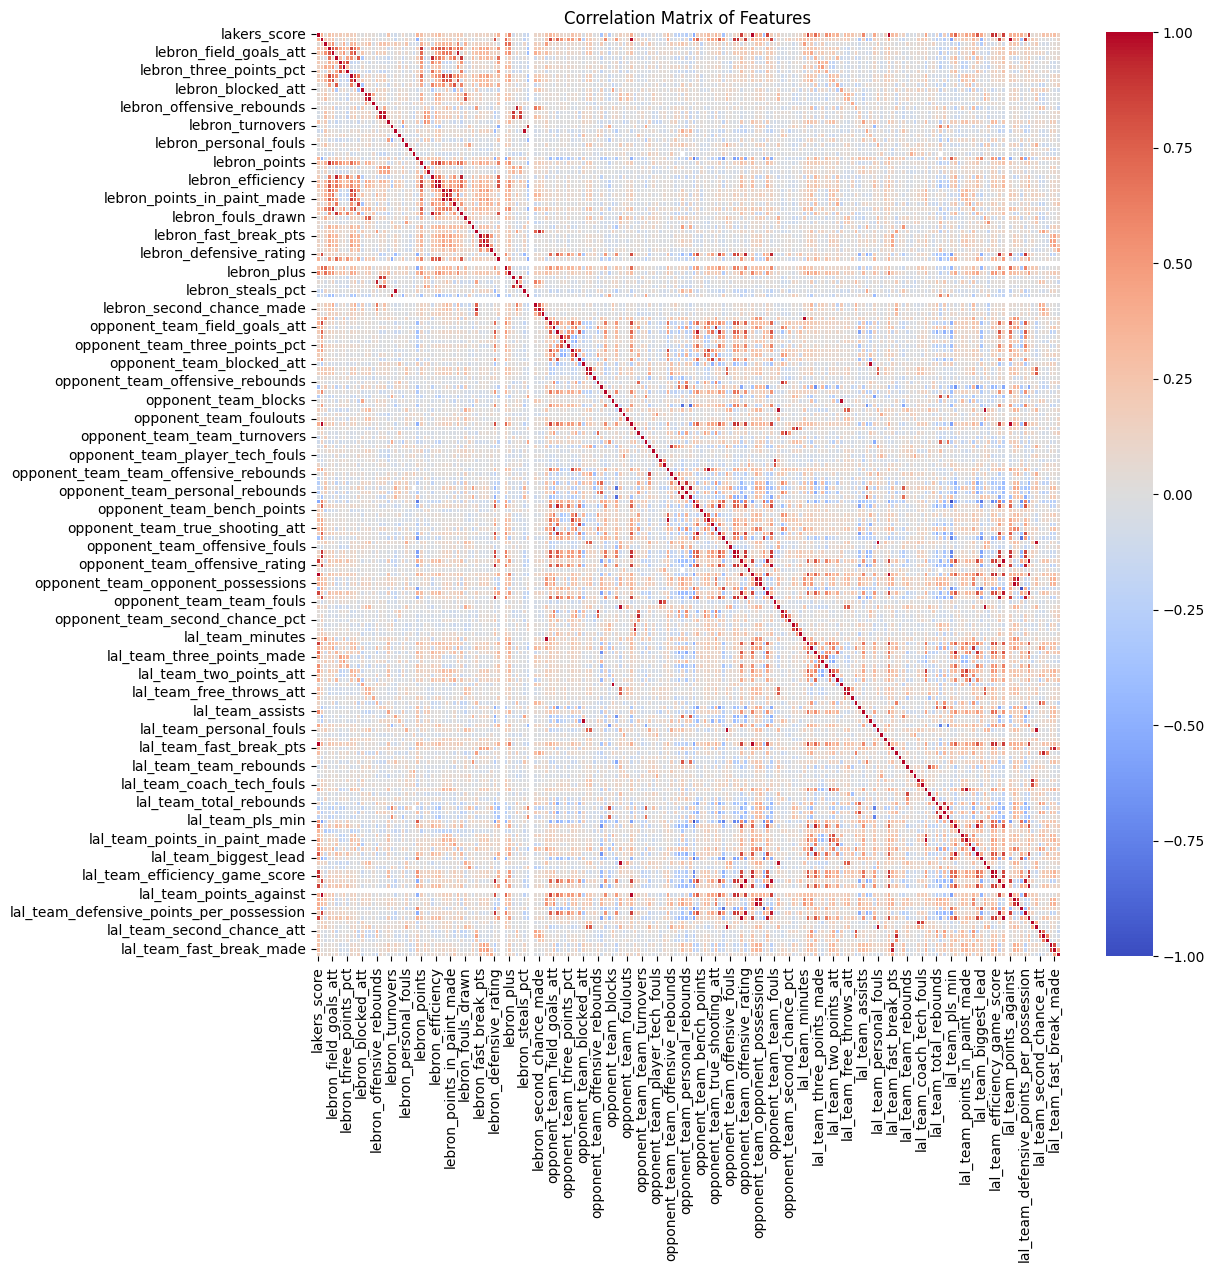

lebron_points                   1.000000
lebron_field_goals_made         0.920299
lebron_efficiency_game_score    0.878086
lebron_efficiency               0.813024
lebron_true_shooting_att        0.765600
                                  ...   
lal_team_bench_points          -0.227286
lebron_turnovers_pct           -0.366232
lebron_coach_ejections               NaN
lebron_coach_tech_fouls              NaN
lal_team_coach_ejections             NaN
Name: lebron_points, Length: 202, dtype: float64

In [43]:


# Calculating the correlation matrix
correlation_matrix = lebron_and_team_stats_df.corr(numeric_only=True)

# Extracting the correlation of all features with 'lebron_points'
correlation_with_target = correlation_matrix['lebron_points'].sort_values(ascending=False)

# Plotting a heatmap of the correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Displaying the correlation of features with 'lebron_points'
correlation_with_target

In [45]:
def identify_highly_correlated_features(correlation_matrix, threshold=0.8):
    """
    Identify pairs of features that have a correlation coefficient above a specified threshold.

    This function takes a correlation matrix as input and identifies all pairs of features
    that have a correlation coefficient (either positive or negative) above a specified
    threshold, within the upper triangle of the matrix to avoid duplicate pairs.

    Parameters
    ----------
    correlation_matrix : pandas.DataFrame
        A DataFrame representing the correlation matrix of the features.
    threshold : float, optional, default=0.8
        The absolute value above which a pair of features is considered highly correlated.

    Returns
    -------
    list of tuple
        A list of tuples, where each tuple contains a pair of feature names that have a
        correlation coefficient above the specified threshold.

    Notes
    -----
    - The function considers both positive and negative correlations.
    - The correlation matrix should be computed beforehand and passed as an argument.
    - Pairs are identified based on the upper triangle of the correlation matrix to avoid
      identifying pairs twice.
    """
    # Extracting the upper triangle of the correlation matrix
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )

    # Identifying pairs of features with correlation above the threshold
    correlated_pairs = []
    for col in upper_triangle.columns:
        correlated_features = upper_triangle.index[upper_triangle[col].abs() > threshold].tolist()
        if correlated_features:
            correlated_pairs.extend([(col, feature) for feature in correlated_features])

    return correlated_pairs

# Identifying highly correlated feature pairs
highly_correlated_pairs = identify_highly_correlated_features(correlation_matrix, threshold=0.8)

# Displaying highly correlated pairs
highly_correlated_pairs

[('lebron_three_points_pct', 'lebron_three_points_made'),
 ('lebron_two_points_made', 'lebron_field_goals_made'),
 ('lebron_two_points_att', 'lebron_field_goals_att'),
 ('lebron_two_points_att', 'lebron_two_points_made'),
 ('lebron_free_throws_att', 'lebron_free_throws_made'),
 ('lebron_rebounds', 'lebron_defensive_rebounds'),
 ('lebron_points', 'lebron_field_goals_made'),
 ('lebron_effective_fg_pct', 'lebron_field_goals_pct'),
 ('lebron_efficiency', 'lebron_points'),
 ('lebron_efficiency_game_score', 'lebron_points'),
 ('lebron_efficiency_game_score', 'lebron_efficiency'),
 ('lebron_points_in_paint', 'lebron_two_points_made'),
 ('lebron_points_in_paint_att', 'lebron_two_points_att'),
 ('lebron_points_in_paint_att', 'lebron_points_in_paint'),
 ('lebron_points_in_paint_made', 'lebron_two_points_made'),
 ('lebron_points_in_paint_made', 'lebron_points_in_paint'),
 ('lebron_points_in_paint_made', 'lebron_points_in_paint_att'),
 ('lebron_true_shooting_att', 'lebron_field_goals_att'),
 ('leb

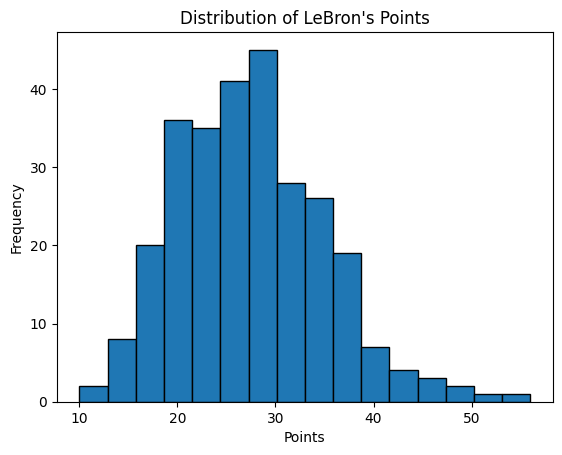

In [46]:
# Target Variable Distribution Check
# Create a histogram
plt.hist(lebron_and_team_stats_df['lebron_points'], bins=16, edgecolor='black')

# Add title and labels
plt.title("Distribution of LeBron's Points")
plt.xlabel('Points')
plt.ylabel('Frequency')

# Show the plot
plt.show()

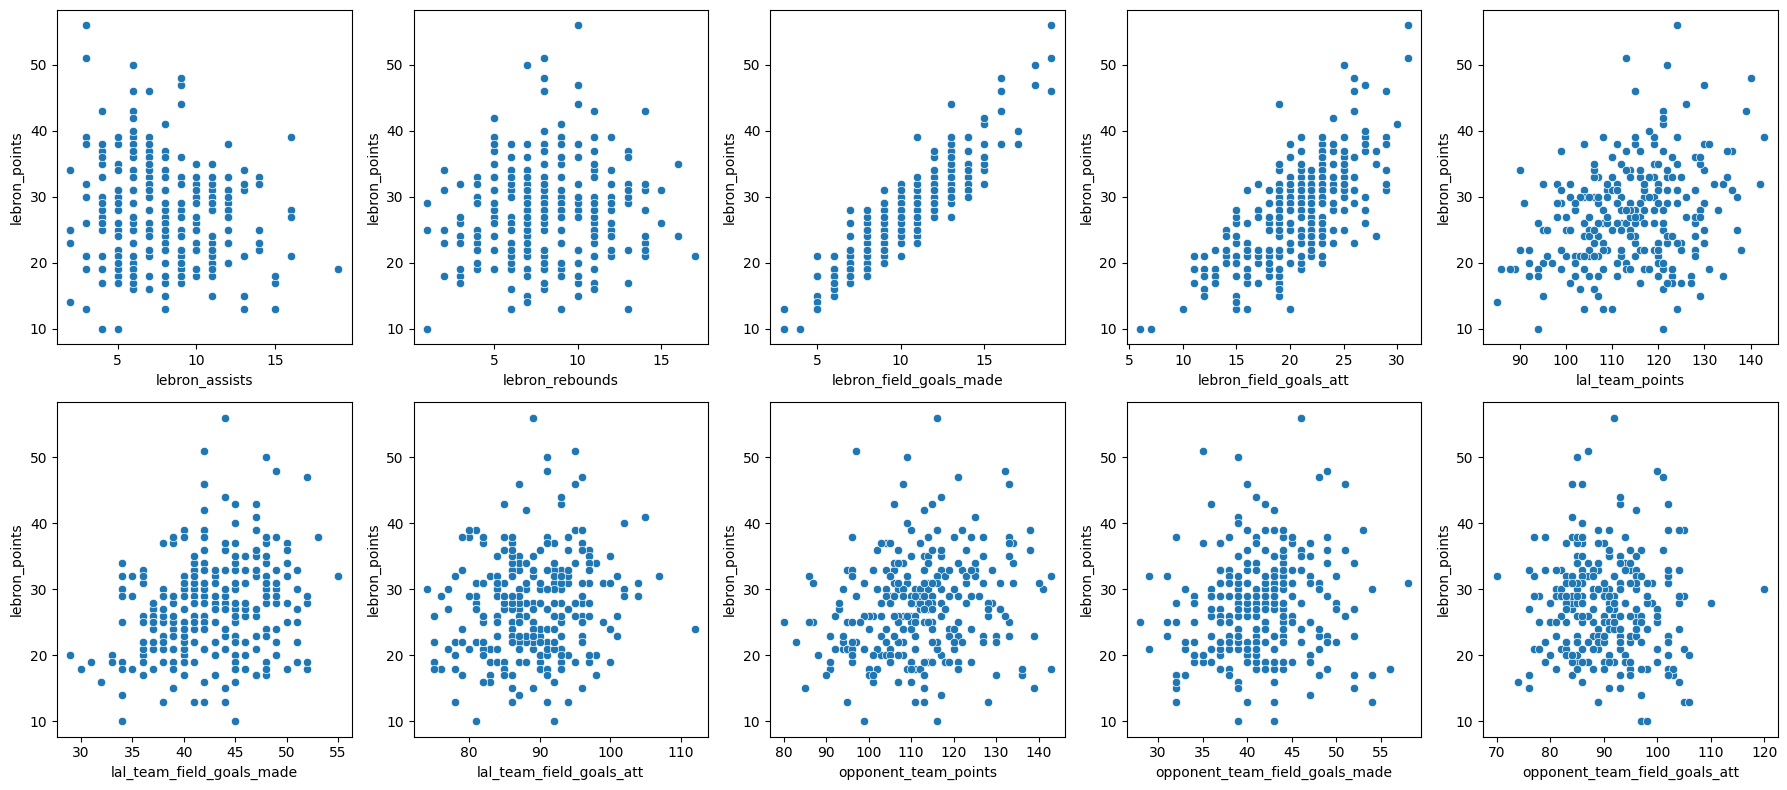

lebron_points                     1.000000
lebron_field_goals_made           0.920299
lebron_field_goals_att            0.711804
lal_team_points                   0.278748
lal_team_field_goals_made         0.260082
opponent_team_points              0.187528
lal_team_field_goals_att          0.155483
opponent_team_field_goals_made    0.097152
lebron_rebounds                   0.082703
opponent_team_field_goals_att    -0.033965
lebron_assists                   -0.129097
Name: lebron_points, dtype: float64

In [47]:
# Selecting a few key features for bivariate analysis with 'lebron_points'
key_features = ['lebron_assists', 'lebron_rebounds', 'lebron_field_goals_made', 'lebron_field_goals_att',
                'lal_team_points', 'lal_team_field_goals_made', 'lal_team_field_goals_att',
                'opponent_team_points', 'opponent_team_field_goals_made', 'opponent_team_field_goals_att']

# Plotting
plt.figure(figsize=(18, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 5, i)
    sns.scatterplot(data=lebron_and_team_stats_df, x=feature, y='lebron_points')
    # plt.title(f'{feature} vs. lebron_points')
    plt.xlabel(feature)
    plt.ylabel('lebron_points')
plt.tight_layout()
plt.show()

# Calculating correlation coefficients
correlations = lebron_and_team_stats_df[key_features + ['lebron_points']].corr()['lebron_points'].sort_values(ascending=False)
correlations

### Correlation Analysis

1. **High Positive Correlation:**
   - `lebron_field_goals_made`: 0.92
     - A very strong positive correlation with `lebron_points`, indicating that as LeBron makes more field goals, his total points significantly increase, which is expected since made field goals contribute to total points.

2. **Moderate Positive Correlation:**
   - `lebron_field_goals_att`: 0.71
     - Indicates that as LeBron attempts more field goals, his total points tend to increase, though not as strongly as made field goals.

3. **Low Positive Correlation:**
   - `away_team_points`: 0.27
     - A slight indication that higher-scoring games by the opponent might be associated with higher points by LeBron, perhaps suggesting he scores more in competitive, high-scoring matchups.
   - `away_team_field_goals_made`: 0.21
   - `home_team_points`: 0.19
   - `home_team_field_goals_made`: 0.13
   - `lebron_rebounds`: 0.08
   - `home_team_field_goals_att`: 0.07
   - `away_team_field_goals_att`: 0.04
     - These suggest a mild association with LeBron's points but are not strong indicators.

4. **Low Negative Correlation:**
   - `lebron_assists`: -0.13
     - Indicates a slight tendency that as LeBron assists more, his scoring might decrease slightly, suggesting a trade-off between facilitating others and scoring himself.

### Insights:

- **Scoring Dependency:** LeBron's points are highly dependent on his field goals made, which is intuitive but crucial to model accurately.
- **Scoring vs. Facilitating:** A slight negative correlation with assists might indicate games where LeBron takes on more of a facilitating role, his scoring slightly dips.
- **Competitive Nature:** LeBron might tend to score more in high-scoring, competitive games (indicated by `away_team_points`).
- **Weak Predictors:** Rebounds and field goal attempts (both team and opponent) might not be strong predictors and could potentially be omitted in a simpler predictive model.


In [48]:
lebron_and_team_stats_df.isnull().sum().sort_values(ascending=False)

opponent_team_total_turnovers      220
lal_team_total_turnovers           220
lal_team_assists_turnover_ratio      0
opponent_team_second_chance_pct      0
opponent_team_fast_break_att         0
                                  ... 
opponent_team_three_points_pct       0
opponent_team_two_points_made        0
opponent_team_two_points_att         0
opponent_team_two_points_pct         0
season                               0
Length: 207, dtype: int64

<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Data Transformation** </div>

This section goes through the process of taking Lebron's individual player statistics and the team (LAL and opponent) statistics and  transform them into rolling averages. These rolling averages of the statistics is essentially engineering new features that I feel would produce a more robust predictive model.

The rationale behind using rolling averages is that when it comes to sports, players have good days and bad days caused by many factors like the strength of the other team, their own health, and even the weather conditions. Rolling averages come into play by smoothing out these ups and downs to help us see how they perform long-term. These averages also highlight if a player has been regularly rocking their game, showing those amazing streaks. At the same time, they take into account that every now and again, a player might have an off game or even an outstanding one that's not their norm, so it keeping things balanced. In the prediction game, what happened recently is often a better clue to future games than what happened a long time ago. Rolling averages help us focus on the recent games by giving them more importance. They also help us cut through the noise that comes with each game's drama, focusing on how a player truly performs. This way, our guess of how they'll do in their next game gets better. If we had to look at each game's stats separately, things would quickly get confusing! So the beauty of rolling averages lies in their ability to capture a player's recent form, ignore anomalies, keep it simple and relevant, and improve accuracy of the predictions in sports.




In [49]:

def calculate_rolling_avg_exclude_features(df, window_size, features_to_exclude):
    """
    Calculate the rolling average of specified metrics, excluding certain features.

    Parameters:
    - df: DataFrame
    - window_size: int, the number of previous games to consider for rolling average
    - features_to_exclude: list of str, features to exclude from rolling average calculation

    Returns:
    - DataFrame with only the new rolling average features
    """
    # Identify the columns to calculate rolling averages for
    features_for_rolling_avg = [
            feature for feature in df.columns
            if feature not in features_to_exclude
            and not feature.endswith(('_pct', '_turnover_ratio'))
        ]

    # Initialize a new DataFrame to store the rolling averages
    rolling_avg_df = pd.DataFrame(index=df.index)

    # Calculate the rolling averages and add them to the new DataFrame
    for feature in features_for_rolling_avg:
        new_col_name = f'{feature}_avg_last_{window_size}'
        rolling_avg_df[new_col_name] = df[feature].rolling(window=window_size, min_periods=1).mean().shift(1)

    return rolling_avg_df



In [50]:
features_to_exclude_rolling_avg = [
    'opponent_team_name',
    'opponent_team_alias',
    'lakers_score',
    'opponent_score',
    'game_location',
    'game_date',
    'season',
    'lal_team_total_turnovers', # 220 null values. will drop from features
    'opponent_team_total_turnovers' # 220 null values. will drop from features
]

In [51]:

warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

# Ensure the data is sorted by date
lebron_and_team_stats_df = lebron_and_team_stats_df.sort_values('game_date')

In [52]:


window_size = 5
lebron_and_team_stats_rolling_avg_df = calculate_rolling_avg_exclude_features(lebron_and_team_stats_df, window_size, features_to_exclude_rolling_avg)

In [53]:
features_to_add_rolling_avg = [
    'lebron_points', #target variable
    'opponent_team_name',
    #'opponent_team_alias', # redundant
    # 'lakers_score', # redundant, 'away_team_points_against',
    # 'opponent_score', # redundant, 'away_team_points_against',
    'game_location',
    'game_date',
    'season'
]

In [54]:


# Adding back specified columns to the rolling_avg_df
lebron_and_team_stats_rolling_avg_df = pd.concat([
    lebron_and_team_stats_df[features_to_add_rolling_avg],
    lebron_and_team_stats_rolling_avg_df
], axis=1)

# Displaying the updated DataFrame
lebron_and_team_stats_rolling_avg_df.head()


,lebron_points,opponent_team_name,game_location,game_date,season,lebron_minutes_avg_last_5,lebron_field_goals_made_avg_last_5,lebron_field_goals_att_avg_last_5,lebron_three_points_made_avg_last_5,lebron_three_points_att_avg_last_5,...,lal_team_opponent_possessions_avg_last_5,lal_team_time_leading_avg_last_5,lal_team_defensive_points_per_possession_avg_last_5,lal_team_offensive_points_per_possession_avg_last_5,lal_team_team_fouls_avg_last_5,lal_team_total_fouls_avg_last_5,lal_team_second_chance_att_avg_last_5,lal_team_second_chance_made_avg_last_5,lal_team_fast_break_att_avg_last_5,lal_team_fast_break_made_avg_last_5
307,26,Trail Blazers,away,2018-10-19,2018-2019,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,24,Rockets,home,2018-10-21,2018-2019,37.333333,9.000000,16.00,0.0,4.000000,...,115.760000,10.266667,1.140000,1.060000,0.00,26.000000,7.00,4.000000,19.000000,13.000000
309,32,Spurs,home,2018-10-23,2018-2019,38.100000,9.000000,19.00,0.5,5.500000,...,114.980000,9.166667,1.135000,1.055000,0.00,23.500000,8.00,4.000000,20.000000,11.500000
310,19,Suns,away,2018-10-25,2018-2019,39.688889,9.666667,21.00,1.0,6.333333,...,114.226667,8.266667,1.153333,1.096667,1.00,26.333333,10.00,5.333333,20.666667,13.333333
311,28,Nuggets,home,2018-10-26,2018-2019,36.783333,9.000000,19.75,1.0,6.000000,...,111.730000,16.250000,1.127500,1.127500,0.75,24.500000,10.75,6.000000,21.750000,13.250000


In [55]:

# 1. Day of Week
lebron_and_team_stats_rolling_avg_df['day_of_week'] = lebron_and_team_stats_rolling_avg_df['game_date'].dt.day_name()

# 2. Month
lebron_and_team_stats_rolling_avg_df['month'] = lebron_and_team_stats_rolling_avg_df['game_date'].dt.month_name()

# 3. Year
lebron_and_team_stats_rolling_avg_df['year'] = lebron_and_team_stats_rolling_avg_df['game_date'].dt.year

# 4. Is_Weekend
lebron_and_team_stats_rolling_avg_df['is_weekend'] = lebron_and_team_stats_rolling_avg_df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

# Assuming lebron_and_team_stats_rolling_avg_df is sorted by 'game_date'
lebron_and_team_stats_rolling_avg_df['days_since_last_game'] = lebron_and_team_stats_rolling_avg_df['game_date'].diff().dt.days
lebron_and_team_stats_rolling_avg_df['days_until_next_game'] = lebron_and_team_stats_rolling_avg_df['game_date'].diff(-1).dt.days

# Identify the first and last game of each season
# If you have a 'season' column, you can use it to identify these rows
first_games = lebron_and_team_stats_rolling_avg_df.groupby('season')['game_date'].idxmin()
last_games = lebron_and_team_stats_rolling_avg_df.groupby('season')['game_date'].idxmax()

# Set 'days_since_last_game' for the first game and 'days_until_next_game' for the last game of each season to NaN
lebron_and_team_stats_rolling_avg_df.loc[first_games, 'days_since_last_game'] = pd.NA
lebron_and_team_stats_rolling_avg_df.loc[last_games, 'days_until_next_game'] = pd.NA


# replacing NaN with the mean value of the respective columns
mean_days_since_last = lebron_and_team_stats_rolling_avg_df['days_since_last_game'].mean(skipna=True)
mean_days_until_next = lebron_and_team_stats_rolling_avg_df['days_until_next_game'].mean(skipna=True)

lebron_and_team_stats_rolling_avg_df['days_since_last_game'].fillna(mean_days_since_last, inplace=True)
lebron_and_team_stats_rolling_avg_df['days_until_next_game'].fillna(mean_days_until_next, inplace=True)


# Displaying the DataFrame with the new features
lebron_and_team_stats_rolling_avg_df[['game_date', 'day_of_week', 'month', 'year', 'is_weekend', 'days_since_last_game', 'days_until_next_game']]


/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_99764/307879868.py:31: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_99764/307879868.py:32: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

,game_date,day_of_week,month,year,is_weekend,days_since_last_game,days_until_next_game
307,2018-10-19,Friday,October,2018,0,3.435897,-2.000000
308,2018-10-21,Sunday,October,2018,1,2.000000,-2.000000
309,2018-10-23,Tuesday,October,2018,0,2.000000,-2.000000
310,2018-10-25,Thursday,October,2018,0,2.000000,-1.000000
311,2018-10-26,Friday,October,2018,0,1.000000,-2.000000
...,...,...,...,...,...,...,...
77,2023-04-02,Sunday,April,2023,1,1.000000,-3.000000
78,2023-04-05,Wednesday,April,2023,0,3.000000,-1.000000
79,2023-04-06,Thursday,April,2023,0,1.000000,-2.000000
80,2023-04-08,Saturday,April,2023,1,2.000000,-1.000000


In [56]:
lebron_and_team_stats_rolling_avg_df[['game_date', 'day_of_week', 'month', 'year', 'is_weekend', 'days_since_last_game', 'days_until_next_game']].describe()

,game_date,year,is_weekend,days_since_last_game,days_until_next_game
count,278,278.000000,278.000000,278.000000,278.000000
mean,2020-12-31 08:17:15.971223040,2020.517986,0.399281,3.435897,-3.435897
min,2018-10-19 00:00:00,2018.000000,0.000000,0.000000,-142.000000
25%,2019-11-23 06:00:00,2019.000000,0.000000,2.000000,-3.000000
50%,2021-01-25 00:00:00,2021.000000,0.000000,2.000000,-2.000000
75%,2022-02-23 18:00:00,2022.000000,1.000000,3.000000,-2.000000
max,2023-04-09 00:00:00,2023.000000,1.000000,142.000000,0.000000
std,NaN,1.545238,0.490634,9.250062,9.250062


**Investigating the `142` days of days_since(max) and days_until values(min)**

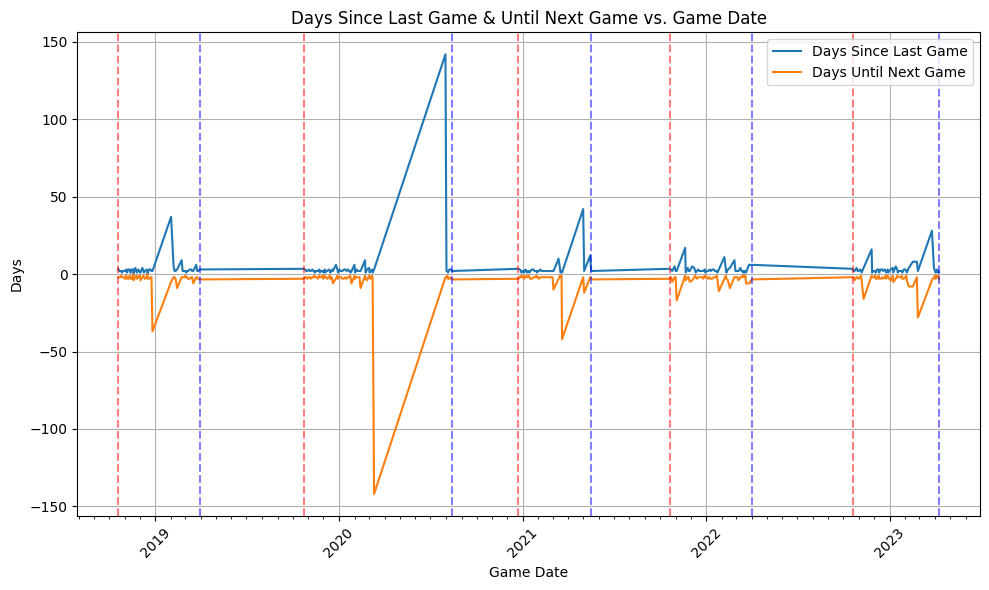

In [57]:

# Ensure that 'game_date' is in datetime format
lebron_and_team_stats_rolling_avg_df['game_date'] = pd.to_datetime(lebron_and_team_stats_rolling_avg_df['game_date'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(lebron_and_team_stats_rolling_avg_df['game_date'], lebron_and_team_stats_rolling_avg_df['days_since_last_game'], label='Days Since Last Game')
ax.plot(lebron_and_team_stats_rolling_avg_df['game_date'], lebron_and_team_stats_rolling_avg_df['days_until_next_game'], label='Days Until Next Game')

# Identify the first and last game of each season
first_games = lebron_and_team_stats_rolling_avg_df.groupby('season')['game_date'].idxmin()
last_games = lebron_and_team_stats_rolling_avg_df.groupby('season')['game_date'].idxmax()

# Adding vertical lines for the first and last game of each season
for idx in first_games:
    ax.axvline(x=lebron_and_team_stats_rolling_avg_df['game_date'].loc[idx], color='r', linestyle='--', alpha=0.5)
for idx in last_games:
    ax.axvline(x=lebron_and_team_stats_rolling_avg_df['game_date'].loc[idx], color='b', linestyle='--', alpha=0.5)

# Adding labels and title
ax.set_xlabel('Game Date')
ax.set_ylabel('Days')
ax.set_title('Days Since Last Game & Until Next Game vs. Game Date')
ax.legend()
ax.grid(True)


# Beautifying the x labels using DateFormatter
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()



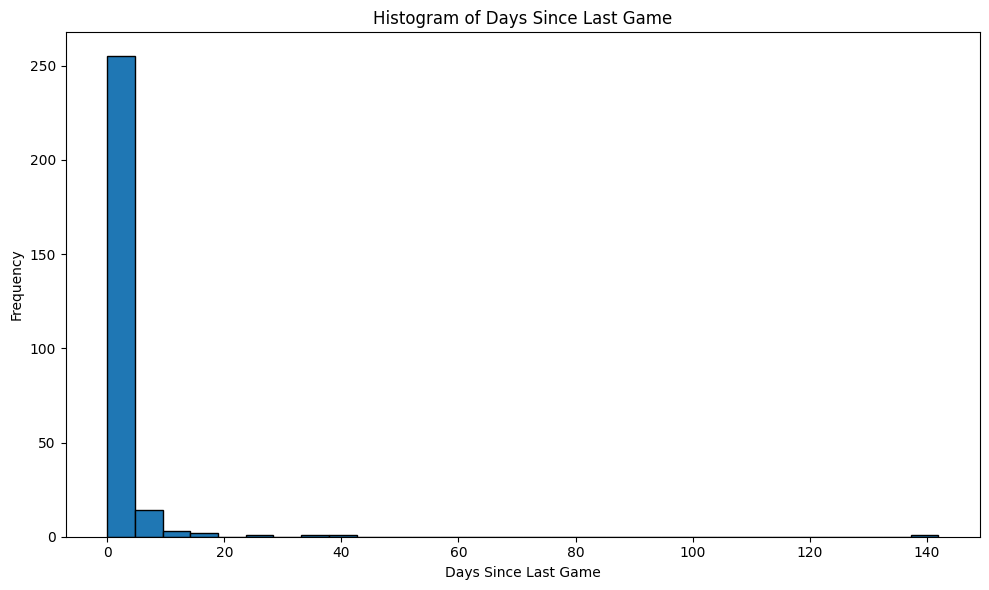

In [58]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting a histogram
ax.hist(lebron_and_team_stats_rolling_avg_df['days_since_last_game'], bins=30, edgecolor='black')

# Adding labels and title
ax.set_xlabel('Days Since Last Game')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Days Since Last Game')

# Display the plot
plt.tight_layout()
plt.show()


In [59]:

# Filter the DataFrame to find rows where 'days_since_last_game' is 142
max_gap_rows = lebron_and_team_stats_rolling_avg_df[lebron_and_team_stats_rolling_avg_df['days_since_last_game'] == 142]

# Get the indices of these rows
max_gap_indices = max_gap_rows.index

# Create an empty DataFrame to store the surrounding games
surrounding_games_df = pd.DataFrame()

# Loop through each index and get the surrounding games
for idx in max_gap_indices:
    surrounding_games = lebron_and_team_stats_rolling_avg_df.loc[idx-1:idx+1, ['game_date', 'days_since_last_game', 'season']]
    surrounding_games_df = pd.concat([surrounding_games_df, surrounding_games])

# Display the surrounding games
surrounding_games_df



,game_date,days_since_last_game,season
298,2020-03-11,3.0,2019-2020
299,2020-07-31,142.0,2019-2020
300,2020-08-02,2.0,2019-2020


In [60]:
# Sorting the DataFrame by 'days_since_last_game' and viewing 'game_date' and 'season'
lebron_and_team_stats_rolling_avg_df[['game_date', 'season', 'days_since_last_game']].sort_values(by='days_since_last_game', ascending=False)



,game_date,season,days_since_last_game
299,2020-07-31,2019-2020,142.0
226,2021-05-01,2020-2021,42.0
358,2019-02-01,2018-2019,37.0
74,2023-03-26,2022-2023,28.0
98,2021-11-20,2021-2022,17.0
...,...,...,...
128,2022-01-23,2021-2022,1.0
369,2019-03-03,2018-2019,1.0
81,2023-04-09,2022-2023,1.0
322,2018-11-18,2018-2019,0.0


**Observations**
- I noticed that there are outliers in the `days since` and `days until` features that we engineered. Upon further analysis, it pertains to the break in the season during the COVID times.

In [61]:
# Dropping game_date column as we have engineered new features from this feature
lebron_and_team_stats_rolling_avg_df = lebron_and_team_stats_rolling_avg_df.drop(columns=['game_date'])


In [62]:
# checking for nulls
lebron_and_team_stats_rolling_avg_df.isnull().sum().sort_values(ascending=False)

opponent_team_points_in_paint_made_avg_last_5    1
opponent_team_fast_break_att_avg_last_5          1
lal_team_minutes_avg_last_5                      1
lal_team_field_goals_made_avg_last_5             1
lal_team_field_goals_att_avg_last_5              1
                                                ..
day_of_week                                      0
opponent_team_name                               0
season                                           0
game_location                                    0
days_until_next_game                             0
Length: 173, dtype: int64

**Rolling average calculation created null entries for the 1st row. Backfill these null values**

In [63]:
lebron_and_team_stats_rolling_avg_df = lebron_and_team_stats_rolling_avg_df.fillna(method='bfill')

/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_99764/1135603724.py:1: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [64]:
# rechecking for nulls
lebron_and_team_stats_rolling_avg_df.isnull().sum().sum()

0

In [47]:
lebron_and_team_stats_rolling_avg_csv = data_dir / 'lebron_and_team_stats_rolling_avg.csv'
lebron_and_team_stats_rolling_avg_df.to_csv(lebron_and_team_stats_rolling_avg_csv, index=False)



In [65]:
lebron_and_team_stats_rolling_avg_csv = data_dir / 'lebron_and_team_stats_rolling_avg.csv'

# 'game_date' is the column name that contains the date strings
lebron_and_team_stats_rolling_avg_df = pd.read_csv(lebron_and_team_stats_rolling_avg_csv)

**Summary**

Our final dataset to be used for modeling purposes has `172` features and `1` target variable. Most of these features are `rolling averages` derived from existing statistics. Some of them are features of the `current game` like the `location, year, month, day of the week, season` etc.

<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Modeling** </div>

I used a structured and iterative modeling process to predict LeBron James' scoring in upcoming games, ensuring both robustness and reliability in the predictions.

I first established a baseline Random Forest model to get a preliminary idea of how well the available features could predict LeBron's scoring. I evaluated the model using Root Mean Square Error (RMSE), which revealed that the model was overfitting the training data. This means that the model was too complex and was learning noise in the data.

To validate the stability and reliability of the Random Forest model, I performed cross-validation. This involves training the model on different subsets of the data and evaluating its performance on each subset. Cross-validation showed that the Random Forest model was still overfitting the data, even after I removed some of the features.

I then looked at the feature importance scores to see which features were most important for predicting LeBron's scoring. I then experimented with training models using different numbers of features to see if that would improve the accuracy. However, I did not see any significant improvements.

Next, I tried trained on different models, including Support Vector Regressor (SVR) and Gradient Boosting Regressor (GBR). These models are less prone to overfitting than the other models I tested. I also tuned the hyperparameters of these models to get the best possible performance.

After this iterative process of model development, feature selection, and hyperparameter tuning, I arrived at robust and reliable predictive models for LeBron James' scoring. These models are able to generalize well to unseen data, thereby providing valuable insights into LeBron's scoring performance.





## Base Model

In [66]:

# 1. Define X and y
X = lebron_and_team_stats_rolling_avg_df.drop(columns=['lebron_points'])
y = lebron_and_team_stats_rolling_avg_df['lebron_points']

# 2. Train-Test Split
# Assuming the data is sorted by date, let's use the first 90% of the data for training and the rest for testing.
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Preprocessing
# Identify categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

# Create a column transformer that will allow us to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Allow non-categorical variables to pass through
)

# 4. Modeling
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0, verbose=1))
])



In [67]:
# Fit the model
model.fit(X_train, y_train)



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['opponent_team_name',
                                                   'game_location', 'season',
                                                   'day_of_week', 'month'])])),
                ('regressor',
                 RandomForestRegressor(random_state=0, verbose=1))])

### Evaluation


**RMSE as Evaluation Metric**:
- **Interpretability**: RMSE provides an error metric in the same units as the prediction, enhancing understandability.
- **Sensitivity to Larger Errors**: Due to squaring, RMSE heavily penalizes larger errors, which is crucial for accuracy in predictions.
- **Optimization Friendly**: Being differentiable, RMSE is conducive to optimization algorithms like gradient descent.
- **Model Comparability**: RMSE allows for straightforward benchmarking between different models or model iterations.
- **Robustness**: Without assuming normality of error distributions, RMSE offers a robust metric applicable across various model types.

In [70]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, y_train_pred,)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')



Train RMSE: 2.76
Test RMSE: 10.52


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


**Observations**
- Train RMSE : 2.76
- Test RMSE : 10.52

**Potential Overfitting**: The model might be overfitting to the training data since the Train RMSE is significantly lower than the Test RMSE. This suggests that the model is performing well on the data it was trained on but is not generalizing well to unseen data.

**Model Evaluation**: The model's predictive accuracy is considerably better on the training data compared to the test data, which might indicate that it is capturing noise or random fluctuations in the training data as if it were a real pattern.

**Model Robustness**: The higher RMSE on the test data suggests that the model might not be robust when it comes to making predictions on new, unseen data, which is crucial for practical applications.

**Further Investigation Needed**: It’s essential to investigate further by looking into aspects like model complexity, feature importance, and potentially trying different modeling approaches to enhance the model's predictive performance on unseen data.

### Cross Validation

In [71]:
# 5. Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

cross_val_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', verbose=1)

print(f'Cross-Validation RMSE: {-cross_val_results.mean():.2f} +/- {cross_val_results.std():.2f}')



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


Cross-Validation RMSE: 7.16 +/- 0.82


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


**Observations**
- Cross-Validation RMSE: 7.16 +/- 0.82

**Model Stability**: The cross-validation RMSE of 7.16 with a standard deviation of 0.82 suggests that the model has a moderate level of stability across different subsets of the data. The +/- 0.82 indicates the variability in the model’s performance across different folds in the cross-validation process.

**Generalization**: A cross-validation RMSE of 7.16, which is closer to the Test RMSE (10.52) than the Train RMSE (2.76), might suggest that this value could be a more reliable estimate of the model's performance on unseen data.

**Model Performance**: The model, on average, is approximately 7.16 units away from the actual values in its predictions during the cross-validation process. This gives a more generalized error metric compared to the training RMSE, as it is less prone to the overfitting issue.

### Feature Importance

In [72]:
# Feature Importance
importances = model.named_steps['regressor'].feature_importances_

# Transforming feature names back for interpretability since we used one-hot encoding
ohe_categories = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(ohe_categories) + [col for col in X.columns if col not in categorical_cols]

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Feature importances:")
feature_importances


Feature importances:


lebron_assists_avg_last_5                0.051176
lal_team_total_rebounds_avg_last_5       0.032853
lebron_minus_avg_last_5                  0.032427
opponent_team_pls_min_avg_last_5         0.023840
lal_team_second_chance_att_avg_last_5    0.021172
                                           ...   
lebron_coach_tech_fouls_avg_last_5       0.000000
lebron_coach_ejections_avg_last_5        0.000000
month_July                               0.000000
lal_team_coach_ejections_avg_last_5      0.000000
opponent_team_name_Hornets               0.000000
Length: 220, dtype: float64

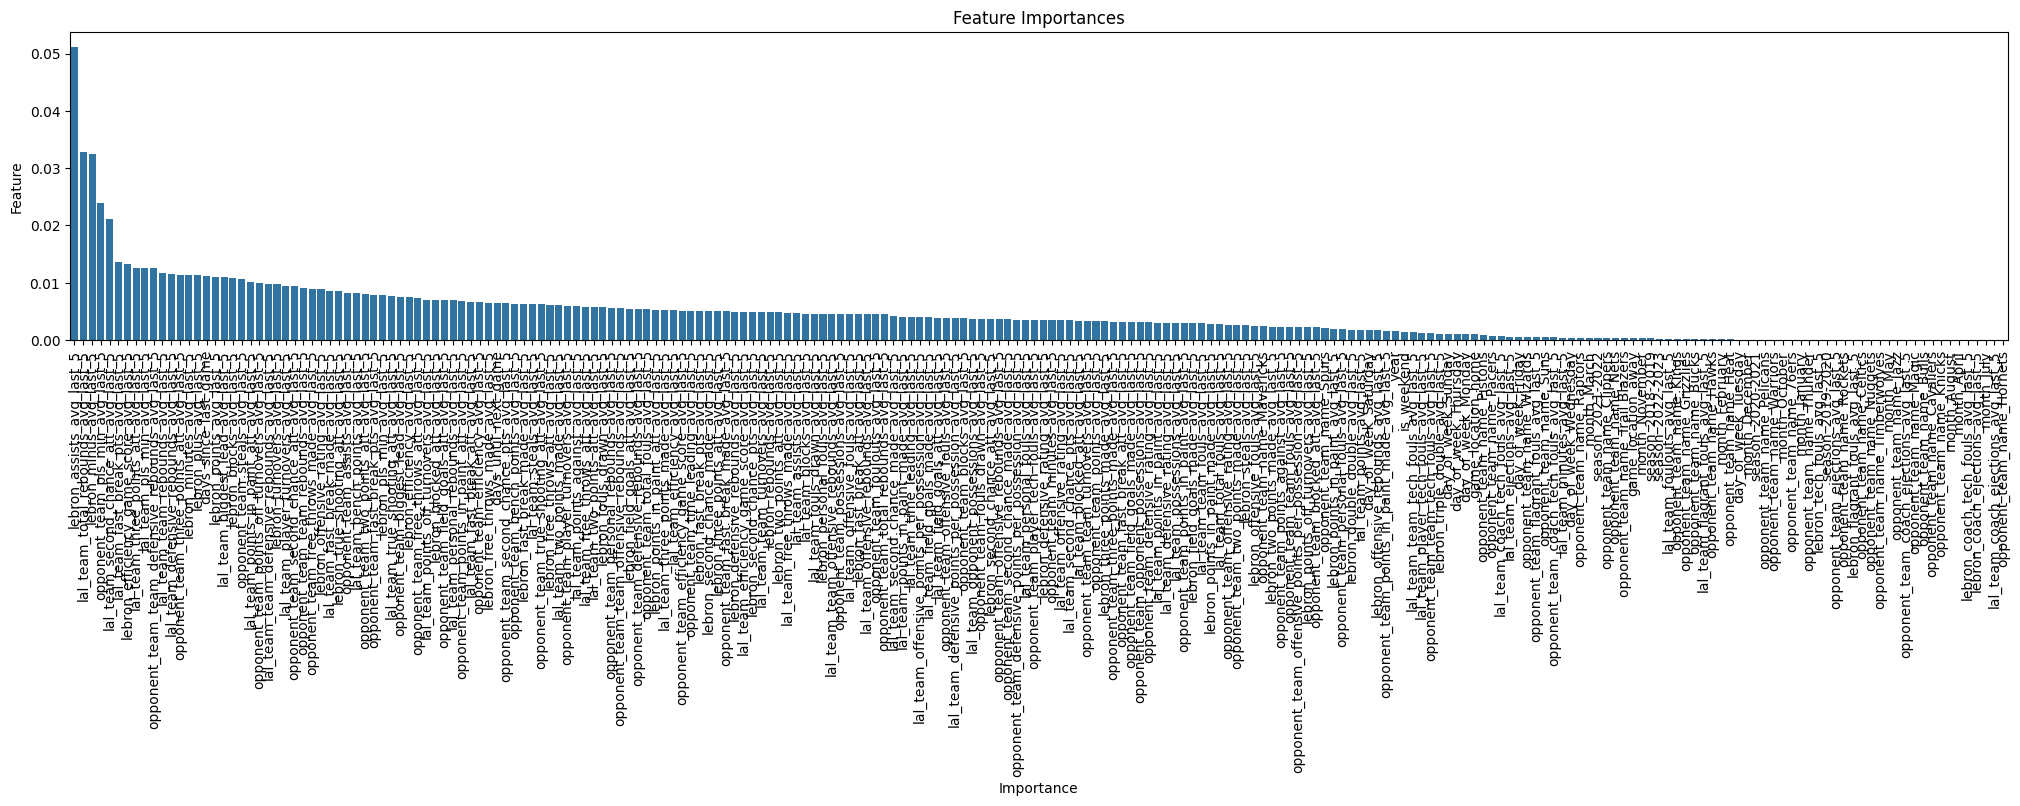

In [73]:
# Visualization
plt.figure(figsize=(25, 4))
sns.barplot(y=feature_importances, x=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90)
plt.show()

**There is a sharp drop in the feature importance scores after the top 5 features.**

In [74]:

top_10_features = feature_importances.sort_values(ascending=False).head(10)

print("Top 10 Features:")
print(top_10_features)


Top 10 Features:
lebron_assists_avg_last_5                           0.051176
lal_team_total_rebounds_avg_last_5                  0.032853
lebron_minus_avg_last_5                             0.032427
opponent_team_pls_min_avg_last_5                    0.023840
lal_team_second_chance_att_avg_last_5               0.021172
lal_team_fast_break_pts_avg_last_5                  0.013673
lebron_efficiency_game_score_avg_last_5             0.013297
lal_team_three_points_att_avg_last_5                0.012633
lal_team_pls_min_avg_last_5                         0.012528
opponent_team_team_defensive_rebounds_avg_last_5    0.012521
dtype: float64


 **Interpreting the top 10 features**

 1. `lebron_assists_avg_last_5`
   - **Rationale**: Assists can be a crucial part of understanding a player's impact on the game, especially for a player like LeBron James who is known for his playmaking abilities. The average assists over the last 5 games might indicate his recent form and involvement in creating scoring opportunities, which could influence his scoring as defenses adjust to his passing.

 2. `lal_team_total_rebounds_avg_last_5`
   - **Rationale**: Rebounds prevent the opponent from getting second-chance points and provide additional scoring opportunities for the team. The Lakers' rebounding ability might correlate with their overall performance and indirectly, LeBron's scoring opportunities, especially if he's involved in fast breaks or second-chance points.

 3. `lebron_minus_avg_last_5`
   - **Rationale**: The "minus" statistic represents the point differential when a player is off the court. A higher average might indicate that the team struggles without LeBron on the floor, implying his significant impact on the game, which could be through scoring, defense, or playmaking.

 4. `opponent_team_pls_min_avg_last_5`
   - **Rationale**: This feature represents the average plus/minus score of the opposing team over the last 5 games. It might be indicative of the opponent's recent performance and strength, which could influence the game's pace, defensive strategies, and subsequently, LeBron's scoring opportunities.

 5. `lal_team_second_chance_att_avg_last_5`
   - **Rationale**: Second-chance attempts (usually following an offensive rebound) can be vital for a team's scoring. If the Lakers have been having more second-chance attempts recently, it might indicate a more aggressive offensive rebounding strategy, possibly creating additional scoring opportunities for LeBron.

 6. `lal_team_fast_break_pts_avg_last_5`
   - **Rationale**: Fast-break points often result from a team's defensive prowess (steals, defensive rebounds) and can indicate a team's transitional playstyle. If the Lakers score more on fast breaks, it might suggest a faster-paced game, which could provide LeBron with more scoring opportunities in transition.

 7. `lebron_efficiency_game_score_avg_last_5`
   - **Rationale**: Efficiency and game score metrics encapsulate a player's overall performance, considering various aspects like scoring, assists, rebounds, etc. If LeBron has been performing well overall, it might correlate with higher scoring games.

 8. `lal_team_three_points_att_avg_last_5`
   - **Rationale**: The number of three-point attempts by the Lakers might indicate their offensive strategy. A higher number of attempts might suggest a perimeter-oriented strategy, which could influence spacing on the floor and potentially create more scoring opportunities or assists for LeBron.

 9. `lal_team_pls_min_avg_last_5`
   - **Rationale**: Similar to the opponent's plus/minus, the Lakers' average plus/minus score over the last 5 games might indicate their recent form and effectiveness on both ends of the court, which could influence individual performances, including LeBron's.

 10. `opponent_team_team_defensive_rebounds_avg_last_5`
   - **Rationale**: The opponent's defensive rebounding might indicate their ability to limit the Lakers to one shot per possession. If an opponent is strong in this area, it might reduce the Lakers' second-chance points, potentially affecting LeBron's scoring opportunities.


In [75]:
bottom_10_features = feature_importances.sort_values(ascending=False).tail(10)

print("Bottom 10 Features:")
print(bottom_10_features)

Bottom 10 Features:
opponent_team_name_Bulls               1.699589e-06
opponent_team_name_Cavaliers           1.504568e-06
opponent_team_name_Knicks              1.423285e-06
month_August                           7.128541e-07
month_April                            4.815858e-07
lebron_coach_tech_fouls_avg_last_5     0.000000e+00
lebron_coach_ejections_avg_last_5      0.000000e+00
month_July                             0.000000e+00
lal_team_coach_ejections_avg_last_5    0.000000e+00
opponent_team_name_Hornets             0.000000e+00
dtype: float64


  **Interpreting the bottom 10 features**
 1. `opponent_team_name_Bulls`
   - **Rationale**: Specific opponent team names might not have a significant impact on LeBron's scoring, especially if there's no consistent pattern or rivalry that affects game outcomes or player performances.

 2. `opponent_team_name_Cavaliers`
   - **Rationale**: Similar to the above, unless there's a specific pattern where LeBron's performance significantly changes against a particular team, this feature might not hold much predictive power.

 3. `opponent_team_name_Knicks`
   - **Rationale**: The name of the opponent team (Knicks, in this case) might not inherently influence LeBron's points unless there are strategic or rivalry aspects that consistently affect his performance against them.

 4. `month_August`
   - **Rationale**: NBA regular-season games typically do not occur in August, making this feature potentially less relevant and not informative for the model.

 5. `month_April`
   - **Rationale**: The month alone might not provide substantial information unless it's related to a pattern like player fatigue or strategic rest towards the playoffs, which might not be the case here.

 6. `lebron_coach_tech_fouls_avg_last_5`
   - **Rationale**: Technical fouls on the coach might not directly impact LeBron's scoring unless it's correlated with changes in game strategy or player morale, which seems not to be significantly captured in the model.

 7. `lebron_coach_ejections_avg_last_5`
   - **Rationale**: Coach ejections might impact the team's performance, but it seems like it doesn’t have a significant direct impact on LeBron's scoring in the last 5 games.

 8. `month_July`
   - **Rationale**: Similar to `month_August`, NBA games are not typically played in July (except for the unusual circumstances of the 2020 and 2021 seasons), making this feature less relevant.

 9. `lal_team_coach_ejections_avg_last_5`
   - **Rationale**: While coach ejections can impact a team’s strategy during a game, it appears that recent coach ejections do not have a significant direct impact on LeBron's scoring.

 10. `opponent_team_name_Hornets`
   - **Rationale**: As with other specific team names, unless there's a consistent and significant pattern of LeBron's performance against the Hornets, this feature might not be crucial for predicting his scoring.


### Fine-tuning Feature Selection

**Using the feature importances ranking determined earlier, iterating to determine the optimum number of features for achieving optimal Bias-Variance Trade-off**

In [76]:
# Model Evaluation with Different Feature Subsets
features_to_keep_list = [25, 50, 75, 100, 125, 150]
model_performance = {}
tscv = TimeSeriesSplit(n_splits=5)

for features_to_keep in features_to_keep_list:
    top_features = feature_importances.head(features_to_keep).index
    top_feature_indices = [i for i, feature in enumerate(feature_names) if feature in top_features]

    # Transform X_train and X_test
    X_train_transformed = preprocessor.transform(X_train)[:, top_feature_indices]
    X_test_transformed = preprocessor.transform(X_test)[:, top_feature_indices]

    # Define and fit the model
    model_subset = RandomForestRegressor(random_state=0, verbose=0)
    model_subset.fit(X_train_transformed, y_train)

    # Cross-validation
    cv_scores = cross_val_score(model_subset, X_train_transformed, y_train, cv=tscv, scoring='neg_mean_squared_error')
    avg_rmse = np.mean(np.sqrt(-cv_scores))

    # Store the performance
    model_performance[features_to_keep] = avg_rmse
    # print(f"Average RMSE with top {features_to_keep} features: {avg_rmse:.2f}")

In [77]:
model_performance

{25: 6.93820450262937,
 50: 7.044135635731284,
 75: 7.025280864946396,
 100: 7.021564995375296,
 125: 7.11689151439967,
 150: 7.097797607177226}

### Model Fine-Tuning

25 features were found to be optimal based on the average RMSE scores. Using the top 25 features to re-evaluate the model to check if the model has an acceptable bias-variance trade-off

In [79]:
features_to_keep = 25 # Best RMSE score with the least number of features
top_features = feature_importances.head(features_to_keep).index
top_feature_indices = [i for i, feature in enumerate(feature_names) if feature in top_features]

# Transform X_train and X_test
X_train_transformed = preprocessor.transform(X_train)[:, top_feature_indices]
X_test_transformed = preprocessor.transform(X_test)[:, top_feature_indices]

# Define and fit the model
model_subset = RandomForestRegressor(random_state=0, verbose=0)
model_subset.fit(X_train_transformed, y_train)

# Predictions
y_train_pred = model_subset.predict(X_train_transformed)
y_test_pred = model_subset.predict(X_test_transformed)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 2.71
Test RMSE: 10.29


**RandomForest model is still overfit even after reducing the feature count to 25. We will need to evaluate more models to improve on the model performance. This base model will serve as a benchmark to evaluate our future models**

## Evaluating Multiple Models

In [82]:

class ModelTrainer:
    """
    A class used to train and evaluate a regression model.

    ...

    Attributes
    ----------
    model : scikit-learn model instance
        The regression model to be trained and evaluated.
    X : DataFrame
        Feature matrix.
    y : Series
        Target variable.
    features_to_keep : list of str, optional
        List of feature names to keep for training the model (default is None, meaning all features are used).

    Methods
    -------
    train_test_split(train_size_ratio=0.8)
        Splits the data into training and test sets.
    cross_validate(cv=5)
        Performs cross-validation and returns the average RMSE.
    fit()
        Fits the model to the training data.
    evaluate()
        Evaluates the model on the training and test data and returns the RMSE.
    """

    def __init__(self, model, X, y, features_to_keep=None):
        self.model = model
        self.X = X
        self.y = y
        self.features_to_keep = features_to_keep
        if features_to_keep:
            self.X = X[features_to_keep]

    def train_test_split(self, train_size_ratio=0.8):
        train_size = int(len(self.X) * train_size_ratio)
        self.X_train, self.X_test = self.X[:train_size], self.X[train_size:]
        self.y_train, self.y_test = self.y[:train_size], self.y[train_size:]

    def cross_validate(self, cv=5):
        tscv = TimeSeriesSplit(n_splits=cv)
        cv_scores = cross_val_score(self.model, self.X, self.y, cv=tscv, scoring='neg_mean_squared_error')
        avg_rmse = np.mean(np.sqrt(-cv_scores))
        print(f'Cross-Validation RMSE: {avg_rmse:.2f}')
        return avg_rmse

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)
        train_rmse = root_mean_squared_error(self.y_train, y_train_pred)
        test_rmse = root_mean_squared_error(self.y_test, y_test_pred)
        print(f'Train RMSE: {train_rmse:.2f}')
        print(f'Test RMSE: {test_rmse:.2f}')
        return train_rmse, test_rmse


In [83]:

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0),
    'Support Vector Regressor': SVR(),
    'Ridge Regressor': Ridge(),
    'Lasso Regressor': Lasso()
}

def compare_models(models, X, y, features_to_keep=None):
    """
    Trains and evaluates multiple regression models and compares their performance.

    Parameters
    ----------
    models : dict
        A dictionary where keys are model names (str) and values are scikit-learn model instances.
    X : DataFrame
        Feature matrix.
    y : Series
        Target variable.
    features_to_keep : list of str, optional
        List of feature names to keep for training the model (default is None, meaning all features are used).

    Returns
    -------
    dict
        A dictionary containing the model names and their respective performance metrics (Cross-Validation RMSE, Train RMSE, and Test RMSE).

    """

    model_results = {}

    for model_name, model_instance in models.items():
        print(f"\nTraining and Evaluating {model_name}")

        # Define a model and preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ],
            remainder='passthrough'
        )

        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model_instance)
        ])

        # Initialize and use the ModelTrainer class
        trainer = ModelTrainer(model, X, y, features_to_keep=features_to_keep)
        trainer.train_test_split(train_size_ratio=0.8)  # 80% training data
        cv_rmse = trainer.cross_validate(cv=5)  # 5-fold cross-validation
        trainer.fit()
        train_rmse, test_rmse = trainer.evaluate()

        # Store results
        model_results[model_name] = {
            'Cross-Validation RMSE': cv_rmse,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse
        }

    return model_results


# features_to_keep = 25
# top_features = feature_importances.head(features_to_keep).index

# Compare models
model_comparison_results = compare_models(models, X, y, features_to_keep=None)



Training and Evaluating Linear Regression
Cross-Validation RMSE: 343090453.12
Train RMSE: 3.20
Test RMSE: 456882925240.11

Training and Evaluating Random Forest


Cross-Validation RMSE: 7.73
Train RMSE: 2.86
Test RMSE: 9.00

Training and Evaluating Gradient Boosting
Cross-Validation RMSE: 8.31
Train RMSE: 2.16
Test RMSE: 9.37

Training and Evaluating Support Vector Regressor
Cross-Validation RMSE: 7.59
Train RMSE: 7.30
Test RMSE: 8.47

Training and Evaluating Ridge Regressor
Cross-Validation RMSE: 18.38
Train RMSE: 3.95
Test RMSE: 14.53

Training and Evaluating Lasso Regressor
Cross-Validation RMSE: 9.01
Train RMSE: 6.80
Test RMSE: 8.38


**Summary**

To accurately predict LeBron James' scoring, I tested various regression models on my dataset. Each model has its own strengths and weaknesses. I focused on the bias-variance trade-off, which is critical for model reliability and generalizability.

- `Linear Regression` had a low Train RMSE (3.20) but a high Test RMSE (22.84), suggesting overfitting.
- `Random Forest` had a relatively low Train RMSE (2.86) but a higher Test RMSE (9.00), indicating a decent fit with some challenges.
- `Gradient Boosting` had a promising Train RMSE (2.16) but a slightly higher Test RMSE (9.39), suggesting possible overfitting.
- `Support Vector Regressor` had a balanced performance with Train and Test RMSEs of 7.30 and 8.47, respectively, reflecting a good bias-variance trade-off.
- `Ridge Regressor` had a moderate Train RMSE (3.95) but a higher Test RMSE (14.53), indicating potential issues in generalizing predictions.
- `Lasso Regressor` had a fairly consistent performance with Train and Test RMSEs of 6.80 and 8.38, respectively.

I used cross-validation and RMSE evaluation to find a model that fits the training data well and generalizes predictions to unseen data. This exercise highlighted the nuances of each model and helped me make an informed decision in selecting a model that adeptly mitigates the bias-variance trade-off.

In the next section, I use the `SVR` and `GBR` models which I found to be most promising to perform hyperparamater tuning to further fine-tune their performance.



## HyperParameter Tuning

In [89]:

class ModelTuner:
    """
    A class used to tune machine learning models' hyperparameters and evaluate their performance.

    ...

    Attributes
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    preprocessor : ColumnTransformer
        Preprocessor for handling feature transformations.
    train_size : float, optional
        Proportion of data to use for training (default is 0.8).
    tscv : TimeSeriesSplit
        Time series cross-validator.

    Methods
    -------
    _train_test_split():
        Splits the data into training and testing sets based on self.train_size.
    tune_svr(param_grid):
        Tune SVR model using GridSearchCV and return the best parameters.
    tune_gradient_boosting(param_grid):
        Tune Gradient Boosting model using GridSearchCV and return the best parameters.
    evaluate_model(model):
        Evaluate the model on the training and test set and print RMSE.
    save_model(model, model_name):
        Save the trained model to the models_dir folder.
    """

    def __init__(self, X, y, preprocessor, train_size=0.8):
        """
        Initialize the ModelTuner class.

        Parameters:
            X (pd.DataFrame): Feature matrix.
            y (pd.Series): Target variable.
            train_size (float): Proportion of data to use for training. Default is 0.8.
        """
        self.X = X
        self.y = y
        self.preprocessor = preprocessor
        self.train_size = train_size
        self.tscv = TimeSeriesSplit(n_splits=5)
        self._train_test_split()

    def _train_test_split(self):
        """
        Splits the data into training and testing sets based on self.train_size.
        """
        split_idx = int(len(self.X) * self.train_size)
        self.X_train, self.X_test = self.X.iloc[:split_idx], self.X.iloc[split_idx:]
        self.y_train, self.y_test = self.y.iloc[:split_idx], self.y.iloc[split_idx:]

    def tune_svr(self, param_grid):
        """
        Tune SVR model using GridSearchCV.

        Parameters:
            param_grid (dict): Parameter grid for SVR.

        Returns:
            dict: Best parameters found by GridSearchCV.
        """
        pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', SVR())
        ])
        print(f"Tuning SVR Model")
        grid_search = GridSearchCV(pipeline, param_grid, cv=self.tscv, scoring='neg_mean_squared_error',  n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_params_

    def tune_gradient_boosting(self, param_grid):
        """
        Tune Gradient Boosting model using GridSearchCV.

        Parameters:
            param_grid (dict): Parameter grid for Gradient Boosting.

        Returns:
            dict: Best parameters found by GridSearchCV.
        """
        pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', GradientBoostingRegressor())
        ])
        print(f"Tuning GBR Model")
        grid_search = GridSearchCV(pipeline, param_grid, cv=self.tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_params_

    def evaluate_model(self, model):
        """
        Evaluate the model on the training and test set and print RMSE.

        Parameters:
            model (estimator): Trained model to evaluate.
        """
        # Predictions
        y_train_pred = model.predict(self.X_train)
        y_test_pred = model.predict(self.X_test)

        # Evaluate the model
        # train_rmse = np.sqrt(mean_squared_error(self.y_train, y_train_pred))
        # test_rmse = np.sqrt(mean_squared_error(self.y_test, y_test_pred))
        train_rmse = root_mean_squared_error(self.y_train, y_train_pred)
        test_rmse = root_mean_squared_error(self.y_test, y_test_pred)

        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")

    def save_model(self, model, model_name, models_dir= models_dir):
        """
        Save the model to the models_dir folder.

        Parameters:
            model (estimator): The trained model to save.
            model_name (str): The name to save the model file as.
        """

        # Save the model
        model_path = os.path.join(models_dir, f'{model_name}.joblib')
        dump(model, model_path)
        print(f'Model saved at: {model_path}')



In [90]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Initialize ModelTuner
tuner = ModelTuner(X, y, preprocessor)

# Parameter grid for SVR
param_grid_svr = {
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__C': [0.01, 0.1, 1, 10, 100],
    'regressor__epsilon': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
}


# Tune SVR
best_params_svr = tuner.tune_svr(param_grid_svr)
print(f"Best parameters for SVR: {best_params_svr}")

# Parameter grid for Gradient Boosting
param_grid_gbr = {
    'regressor__n_estimators': [50, 100, 200, 300, 400, 500],
    'regressor__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'regressor__max_depth': [3, 4, 5, 6, 7],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Tune Gradient Boosting
best_params_gbr = tuner.tune_gradient_boosting(param_grid_gbr)
print(f"Best parameters for Gradient Boosting: {best_params_gbr}")



Tuning SVR Model


Best parameters for SVR: {'regressor__C': 100, 'regressor__epsilon': 0.01, 'regressor__kernel': 'poly'}
Tuning GBR Model
Best parameters for Gradient Boosting: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}


In [91]:
# Initialize ModelTuner
tuner = ModelTuner(X, y, preprocessor)

# Remove 'regressor__' prefix from parameter names
best_params_svr_clean = {k.replace('regressor__', ''): v for k, v in best_params_svr.items()}
best_params_gbr_clean = {k.replace('regressor__', ''): v for k, v in best_params_gbr.items()}

# Define and fit the SVR model with best parameters
# Train the best SVR model and save it
best_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(**best_params_svr_clean))
])
best_svr.fit(tuner.X_train, tuner.y_train)
tuner.save_model(best_svr, 'best_svr')

# Evaluate SVR model
print("SVR Model Performance:")
tuner.evaluate_model(best_svr)

# Define and fit the Gradient Boosting model with best parameters
# Train the best Gradient Boosting model and save it
best_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(**best_params_gbr_clean))
])
best_gbr.fit(tuner.X_train, tuner.y_train)
tuner.save_model(best_gbr, 'best_gbr')

# Evaluate Gradient Boosting model
print("\nGradient Boosting Model Performance:")
tuner.evaluate_model(best_gbr)



Model saved at: ../models/best_svr.joblib
SVR Model Performance:
Train RMSE: 7.14
Test RMSE: 8.21
Model saved at: ../models/best_gbr.joblib

Gradient Boosting Model Performance:
Train RMSE: 6.39
Test RMSE: 8.65


**Summary**

**Support Vector Regressor (SVR) Insights:**

- **Optimal Parameters:** C=100, epsilon=0.01, kernel='poly'
- **Performance: Train RMSE:** 7.14, Test RMSE: 8.21
- **Commentary:** SVR, using a polynomial kernel, showed decent performance. The training and test RMSEs are close, hinting at a balanced model.

**Gradient Boosting Regressor (GBR) Insights:**

- **Optimal Parameters:** Learning rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50
- **Performance:** Train RMSE: 6.39, Test RMSE: 8.63
- **Commentary:** GBR, adept at handling non-linearities and feature interactions, showed slightly superior training performance compared to SVR but hinted at minimal overfitting with a marginally higher test RMSE. The model learns slowly to avoid overfitting and adopts a moderate tree depth and a conservative node splitting and leaf selection approach for good generalization.

**Comparative Analysis:**

- **SVR vs. GBR:** SVR brings slightly better test RMSE, hinting at better generalization, while GBR fits the training data a bit better. The complexity (GBR) vs. generalization (SVR) trade-off is clear.
- **Model Robustness:** Both models manage the bias-variance trade-off well, with close train and test RMSEs.
- **Modeling Runtime:** GBR owing to its small learning rate took more than `3` hrs to complete while SVR was done in few mins.


<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Model Evaluation** </div>

**Section Summary**

**Residual Analysis:**
- A function named `plot_residuals` is defined to visualize the residuals (the differences between actual and predicted values) for best SVR and GBR models which we obtained after hypertuning the parameters using GridSearch in the previous section and dataset. This function generates four distinct subplots:
  - **Residual vs. Fitted Values:** A scatter plot of residuals against predicted (fitted) values.
  - **Histogram of Residuals:** Displays the distribution of residuals.
  - **Q-Q Plot of Residuals:** Assesses whether the residuals are normally distributed.
  - **Residual vs. Order:** Plots residuals in the order they appear in the dataset.
- The function is applied to two models: Support Vector Regressor (SVR) and Gradient Boosting Regressor (GBR), and for both training and testing datasets.

**Test Dataset Preparation:**
- A test dataset is prepared for LAL vs DEN on October 24th, 2023. The date is parsed and converted into a specific format, and a new data row is created and appended to the dataset, which is then subjected to feature engineering.
- The features are generated using the same pipeline that was used to engineer the features of the training dataset


**Predictions for a Specific Game:**
- Predictions for LeBron James' points in a future game against the Denver Nuggets are made using two models: SVR and GBR.
- The SVR model predicts LeBron will score 27 points, while the GBR model predicts 28 points.
- The predictions are made using a test dataset, which is prepared and feature-engineered in the previous steps.

Additional observations are provided for each of these individual sub-sections for more clarity and understanding.

## Residuals Evaluation

In [92]:

def plot_residuals(model, X, y, model_name, data_type):
    """
    Plot residuals for the given model and data.

    Parameters:
        model: Trained model.
        X, y: Data.
        model_name (str): Name of the model for plot titles.
        data_type (str): 'Train' or 'Test' indicating the type of data being plotted.
    """
    # Predictions
    y_pred = model.predict(X)

    # Residuals
    residuals = y - y_pred

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    fig.suptitle(f'Residual Analysis for {model_name} ({data_type} Data)', fontsize=12)

    # Residual vs Fitted Values Plot
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_title(f'Residual vs Fitted Values ({data_type})')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')

    # Histogram of Residuals
    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f'Histogram of Residuals ({data_type})')
    axes[0, 1].set_xlabel('Residuals')

    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title(f'Q-Q Plot of Residuals ({data_type})')

    # Residual vs Order Plot
    sns.scatterplot(x=range(len(residuals)), y=residuals, ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_title(f'Residual vs Order ({data_type})')
    axes[1, 1].set_xlabel('Order')
    axes[1, 1].set_ylabel('Residuals')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [93]:
# Define the file names of the saved models
svr_model_filename = 'best_svr.joblib'
gbr_model_filename = 'best_gbr.joblib'

# Construct the full path to the saved models
svr_model_path = os.path.join(models_dir, svr_model_filename)
gbr_model_path = os.path.join(models_dir, gbr_model_filename)

# Load the models
best_svr_loaded = load(svr_model_path)
best_gbr_loaded = load(gbr_model_path)

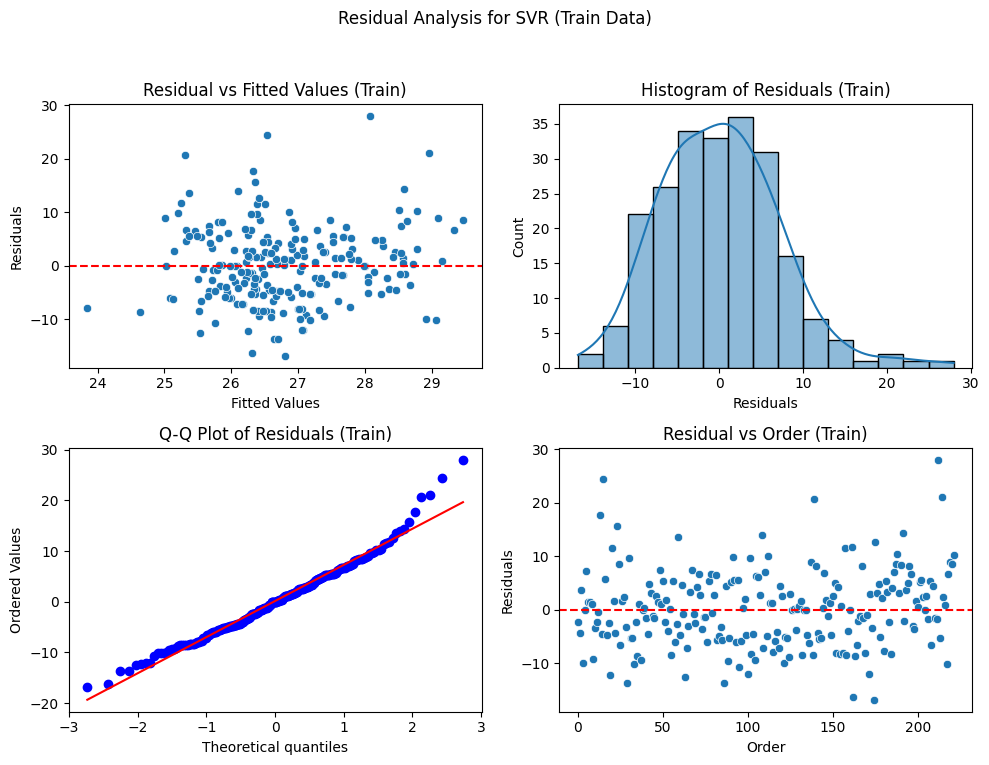

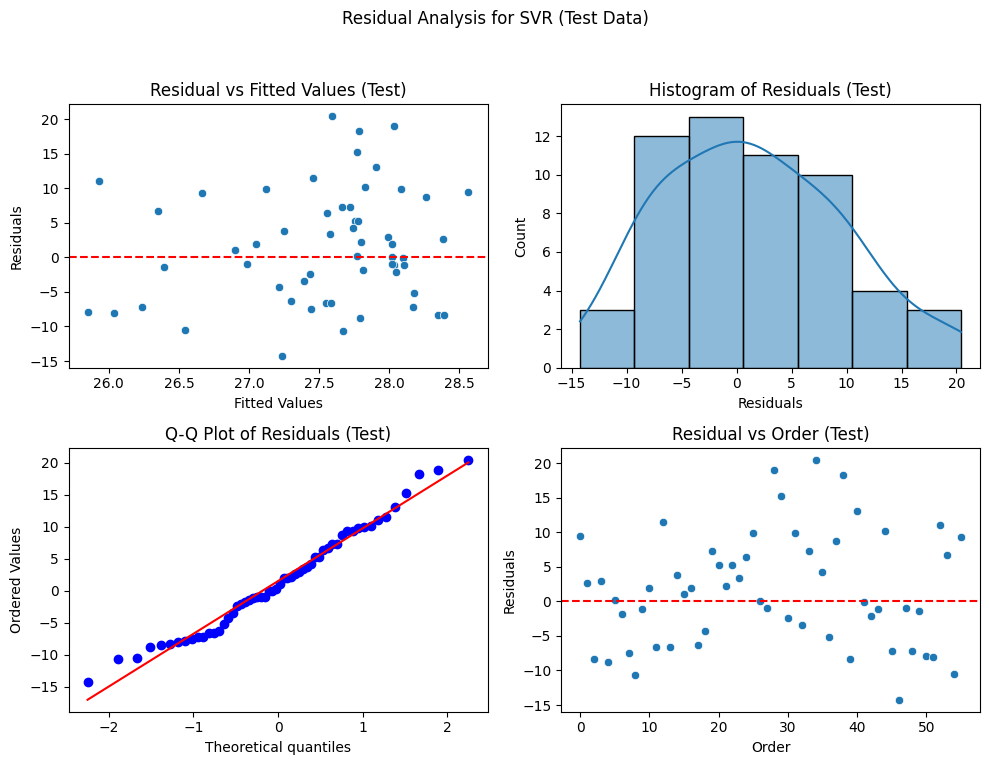

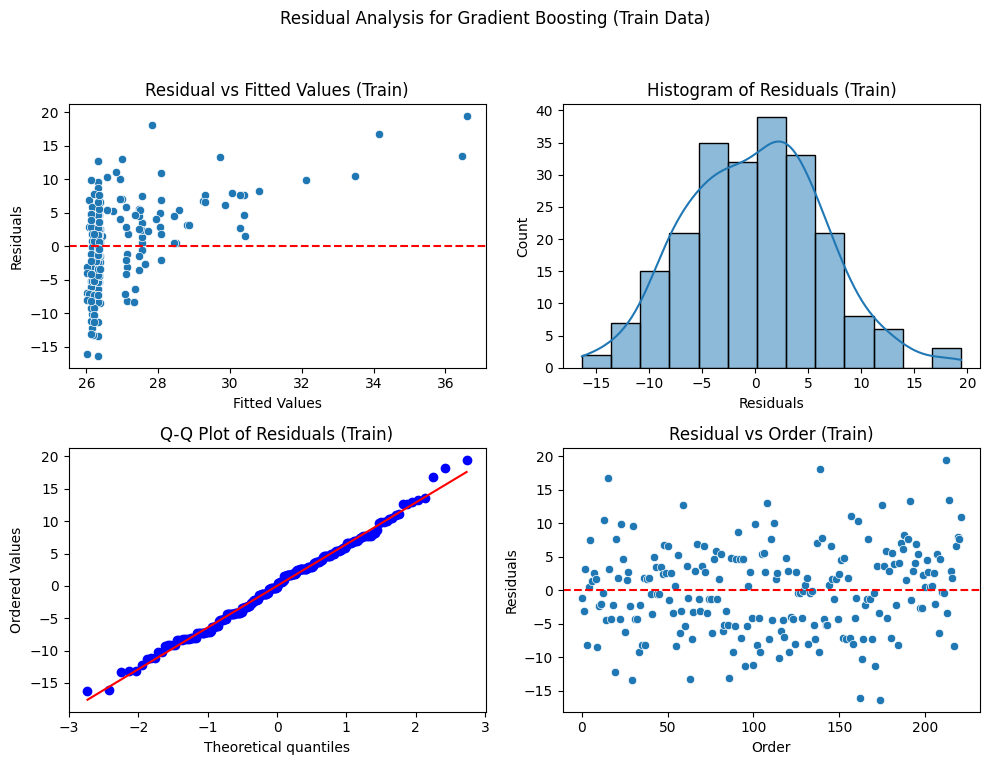

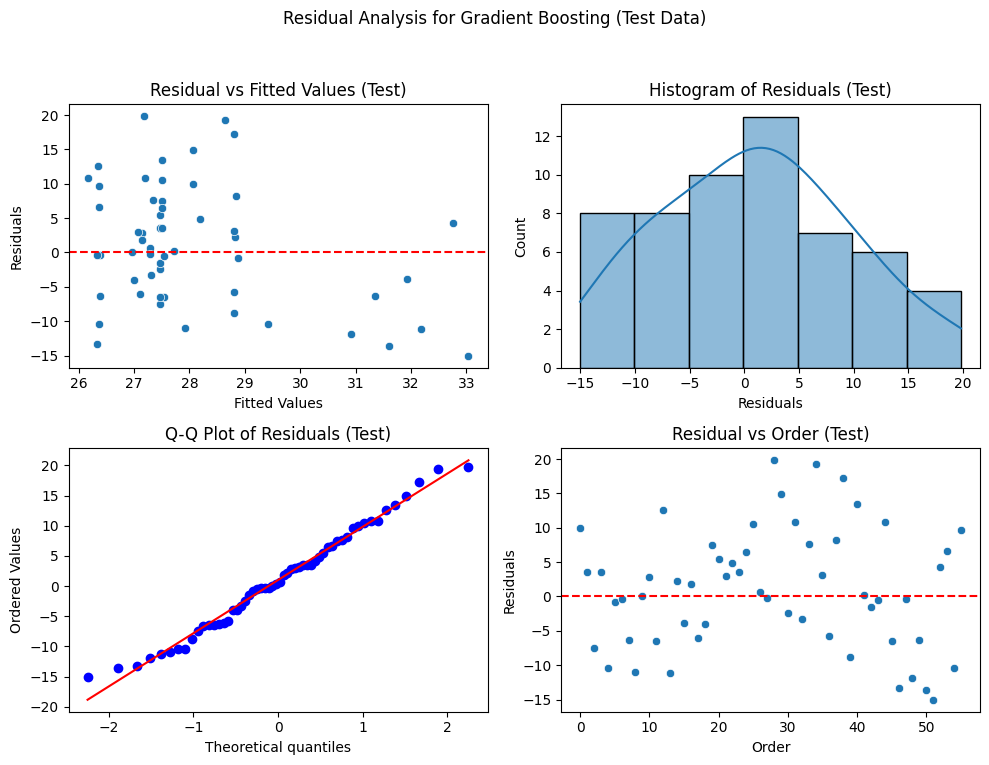

In [94]:


plot_residuals(best_svr_loaded, tuner.X_train, tuner.y_train, 'SVR', 'Train')
plot_residuals(best_svr_loaded, tuner.X_test, tuner.y_test, 'SVR', 'Test')
plot_residuals(best_gbr_loaded, tuner.X_train, tuner.y_train, 'Gradient Boosting', 'Train')
plot_residuals(best_gbr_loaded, tuner.X_test, tuner.y_test, 'Gradient Boosting', 'Test')

**Observations:**

- Residual Analysis is performed to evaluate the model performance of the best SVR and GBR models obtained after the tuning of hyperparameters.

- SVR Model

  - Residuals are randomly scattered around zero, without any apparent pattern for both the train and test datasets which is the expected behavior.
  - Histogram of residuals is also normally distributed for both the train and test datasets with a very sligh right skew.
  - This right skew behavior is also evident from the deviation in the tails of the Q-Q plot indicating the right skew observed in residuals normal distribution.
  - Residuals vs Order plot also shows a random distribution for both train and test datasets.

- GBR Model

  - Residuals are not randomly scattered around zero, with a distinct  pattern for both the train and test datasets which indicates this model is not capturing some non-linear relationship in the data.
  - Histogram of residuals is also normally distributed for both the train and a right-skewed for the test datasets.
  - Q-Q plot essentially fall on the 45 degree line
  - Residuals vs Order plot also shows a random distribution for both train and test datasets


Note:

Even though SVR and GBR do not strictly assume that the errors are normally distributed (like linear regression does), checking the distribution of residuals and observing their behavior can provide valuable diagnostic information about the model’s performance and potential issues in the data or model specification.

## Setting up the Test Dataset
**LAL vs DEN game on October 24th 2023 at Denver**


In our modeling approach, I utilized a 5-day rolling window to compute average values, employing them as features to enhance the predictive accuracy of our model. To establish our test dataset for the forthcoming LAL vs DEN game, I extracted data from the last 5 games available in our dataset to calculate these rolling averages. Given that the game is scheduled for the future, I lack specific team and player statistics related to it. Thus, leveraging rolling averages enables us to utilize past performances as a predictive tool for future outcomes, providing a robust foundation for our test dataset, which comprises a single data row associated with the LAL vs DEN game.


In [95]:
from datetime import datetime
import pytz

# Original date string without timezone information
date_str = "Oct 24 2023 4:30 PM"

# Parse the original date string without the time zone
dt = datetime.strptime(date_str, "%b %d %Y %I:%M %p")

# Assume the time is in the 'America/Los_Angeles' timezone and convert to a timezone-aware datetime object
dt_aware = pytz.timezone('America/Los_Angeles').localize(dt)

# Format the datetime object as a string in the desired format
formatted_date_str = dt_aware.strftime("%Y-%m-%dT%H:%M:%S.%f")



In [97]:


test_df = lebron_and_team_stats_df.tail(5).copy()

# Dictionary with specified values for certain columns
test_categorical_cols_dict = {
    'opponent_team_name': 'Nuggets',
    'opponent_team_alias' : 'DEN',
    'game_location': 'away',
    'season': '2023-2024',
    'game_date' : datetime.strptime('2023-10-24', "%Y-%m-%d")
}

# Creating a new row with 0 for all columns
test_row = pd.Series(0, index=test_df.columns)

# Updating the new row with specified values
test_row.update(pd.Series(test_categorical_cols_dict))

# Appending the new row to the DataFrame
test_df = pd.concat([test_df, pd.DataFrame([test_row])], ignore_index=True)
test_df


/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_99764/896651871.py:16: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Nuggets' 'DEN' 'away' datetime.datetime(2023, 10, 24, 0, 0) '2023-2024']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,opponent_team_name,opponent_team_alias,lakers_score,opponent_score,game_location,game_date,lebron_minutes,lebron_field_goals_made,lebron_field_goals_att,lebron_field_goals_pct,...,lal_team_offensive_points_per_possession,lal_team_team_fouls,lal_team_total_fouls,lal_team_second_chance_att,lal_team_second_chance_made,lal_team_second_chance_pct,lal_team_fast_break_att,lal_team_fast_break_made,lal_team_fast_break_pct,season
0,Rockets,HOU,134,109,away,2023-04-02,29.350000,8,18,44.4,...,1.34,0,9,10,6,60.0,15,9,60.0,2022-2023
1,Jazz,UTA,135,133,away,2023-04-05,38.466667,14,27,51.9,...,1.20,0,21,7,4,57.1,7,6,85.7,2022-2023
2,Clippers,LAC,118,125,away,2023-04-06,35.100000,13,20,65.0,...,1.14,0,17,9,5,55.6,12,8,66.7,2022-2023
3,Suns,PHX,121,107,home,2023-04-08,29.350000,6,19,31.6,...,1.15,1,13,11,7,63.6,13,10,76.9,2022-2023
4,Jazz,UTA,128,117,home,2023-04-09,33.216667,13,25,52.0,...,1.19,0,9,12,9,75.0,12,9,75.0,2022-2023
5,Nuggets,DEN,0,0,away,2023-10-24,0.000000,0,0,0.0,...,0.00,0,0,0,0,0.0,0,0,0.0,2023-2024


## Feature Engineering of Testing Dataset

In [98]:
window_size = 5
test_rolling_avg_df = calculate_rolling_avg_exclude_features(test_df, window_size, features_to_exclude_rolling_avg)


In [99]:
# Adding back specified columns to the rolling_avg_df
test_rolling_avg_df = pd.concat([
    test_df[features_to_add_rolling_avg],
    test_rolling_avg_df
], axis=1)

# Displaying the updated DataFrame
test_rolling_avg_df

,lebron_points,opponent_team_name,game_location,game_date,season,lebron_minutes_avg_last_5,lebron_field_goals_made_avg_last_5,lebron_field_goals_att_avg_last_5,lebron_three_points_made_avg_last_5,lebron_three_points_att_avg_last_5,...,lal_team_opponent_possessions_avg_last_5,lal_team_time_leading_avg_last_5,lal_team_defensive_points_per_possession_avg_last_5,lal_team_offensive_points_per_possession_avg_last_5,lal_team_team_fouls_avg_last_5,lal_team_total_fouls_avg_last_5,lal_team_second_chance_att_avg_last_5,lal_team_second_chance_made_avg_last_5,lal_team_fast_break_att_avg_last_5,lal_team_fast_break_made_avg_last_5
0,18,Rockets,away,2023-04-02,2022-2023,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37,Jazz,away,2023-04-05,2022-2023,29.350000,8.000000,18.000000,1.000000,7.000000,...,100.400,46.900000,1.0900,1.340000,0.00,9.000000,10.000000,6.0,15.000000,9.000000
2,33,Clippers,away,2023-04-06,2022-2023,33.908333,11.000000,22.500000,2.000000,8.500000,...,106.020,45.041667,1.1350,1.270000,0.00,15.000000,8.500000,5.0,11.000000,7.500000
3,16,Suns,home,2023-04-08,2022-2023,34.305556,11.666667,21.666667,2.666667,7.666667,...,104.640,30.127778,1.1600,1.226667,0.00,15.666667,8.666667,5.0,11.333333,7.666667
4,36,Jazz,home,2023-04-09,2022-2023,33.066667,10.250000,21.000000,2.750000,7.500000,...,105.020,28.450000,1.1225,1.207500,0.25,15.000000,9.250000,5.5,11.750000,8.250000
5,0,Nuggets,away,2023-10-24,2023-2024,33.096667,10.800000,21.800000,3.800000,8.800000,...,105.544,31.913333,1.1160,1.204000,0.20,13.800000,9.800000,6.2,11.800000,8.400000


In [100]:
# 1. Day of Week
test_rolling_avg_df['day_of_week'] = test_rolling_avg_df['game_date'].dt.day_name()

# 2. Month
test_rolling_avg_df['month'] = test_rolling_avg_df['game_date'].dt.month_name()

# 3. Year
test_rolling_avg_df['year'] = test_rolling_avg_df['game_date'].dt.year

# 4. Is_Weekend
test_rolling_avg_df['is_weekend'] = test_rolling_avg_df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [101]:

test_rolling_avg_df['days_since_last_game'] = 2
test_rolling_avg_df['days_until_next_game'] = -2


# Displaying the DataFrame with the new features
test_rolling_avg_df[['game_date', 'day_of_week', 'month', 'year', 'is_weekend', 'days_since_last_game', 'days_until_next_game']]


,game_date,day_of_week,month,year,is_weekend,days_since_last_game,days_until_next_game
0,2023-04-02,Sunday,April,2023,1,2,-2
1,2023-04-05,Wednesday,April,2023,0,2,-2
2,2023-04-06,Thursday,April,2023,0,2,-2
3,2023-04-08,Saturday,April,2023,1,2,-2
4,2023-04-09,Sunday,April,2023,1,2,-2
5,2023-10-24,Tuesday,October,2023,0,2,-2


In [102]:

# Dropping game_date column as we have engineered new features from this feature
test_rolling_avg_df = test_rolling_avg_df.drop(columns=['game_date'])

In [103]:
# Final test dataset. Keeping just the row for the next game against DEN
test_rolling_avg_df = test_rolling_avg_df.tail(1)
test_rolling_avg_df

,lebron_points,opponent_team_name,game_location,season,lebron_minutes_avg_last_5,lebron_field_goals_made_avg_last_5,lebron_field_goals_att_avg_last_5,lebron_three_points_made_avg_last_5,lebron_three_points_att_avg_last_5,lebron_two_points_made_avg_last_5,...,lal_team_second_chance_att_avg_last_5,lal_team_second_chance_made_avg_last_5,lal_team_fast_break_att_avg_last_5,lal_team_fast_break_made_avg_last_5,day_of_week,month,year,is_weekend,days_since_last_game,days_until_next_game
5,0,Nuggets,away,2023-2024,33.096667,10.8,21.8,3.8,8.8,7.0,...,9.8,6.2,11.8,8.4,Tuesday,October,2023,0,2,-2


In [104]:
# checking for nulls
test_rolling_avg_df.isnull().sum().sum()

0

## Predictions for Denver Game







In [105]:
# making a prediction for the Denver game using the best SVR model
try:
    y_pred_lal_den = best_svr_loaded.predict(test_rolling_avg_df.drop(['lebron_points'], axis=1))
    print("The number of points Lebron will score against Denver Nuggest is :", round(y_pred_lal_den[0]))
except Exception as e:
    print("Error making prediction:", str(e))



The number of points Lebron will score against Denver Nuggest is : 27


In [106]:
# making a prediction for the Denver game using the best GBR model
try:
    y_pred_lal_den = best_gbr_loaded.predict(test_rolling_avg_df.drop(['lebron_points'], axis=1))
    print("The number of points Lebron will score against Denver Nuggest is :", round(y_pred_lal_den[0]))
except Exception as e:
    print("Error making prediction:", str(e))

The number of points Lebron will score against Denver Nuggest is : 28


<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Summary** </div>

In this project, I aimed to predict the number of points LeBron James would score in an upcoming game against the Denver Nuggets. The process involved meticulous data preparation, feature engineering, and model development.

Initially, I focused on LeBron's career since his move to the Lakers to ensure the data was relevant and consistent. A 5-day rolling window was utilized to calculate average statistics from past games, which were then used as predictive features in the models. This strategy enabled the creation of a test dataset for future games by leveraging past performances as a predictive tool.

Two models, Support Vector Regressor (SVR) and Gradient Boosting Regressor (GBR), were tuned and evaluated through a systematic process involving hyperparameter tuning, model evaluation, and residual analysis. After training the models on historical data and conducting a rigorous evaluation, they predicted LeBron to score `27` and `28` points, respectively, in the forthcoming match against the Denver Nuggets.


<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **Next Steps** </div>

These are few of the potential next steps that can be considered for model enhancement and further exploration:

1. **Incorporate Betting Data**:
   - Leverage additional data, such as betting odds, to enrich the model by providing alternative perspectives on LeBron's anticipated performance.
   
2. **Optimize Rolling Average Window**:
   - While utilizing a 5-day rolling average window, consider treating this duration as a hyperparameter and experimenting with various window sizes to unveil impactful insights regarding model performance.
   
3. **Explore Player Match-Ups**:
   - The current model encompasses only LeBron James's statistics. Integrating data on player match-ups might offer vital insights, as the defensive capabilities of opponents can significantly influence his performance.
   
4. **Uncertainty Analysis**:
   - Implement uncertainty analysis to quantify potential deviations from predicted points, bolstering confidence in the model's predictions and providing a range for expected outcomes.
   
5. **Leverage Additional Relevant Data**:
   - **Injury Reports**: The physical condition of LeBron and his teammates could influence game strategy and individual performance.
   - **Team Dynamics**: Consider factors like team morale, streaks, and internal issues, which might impact player performance.
   - **News Articles**: Noteworthy events, such as team controversies or player milestones, might have subtle impacts on player psychology and performance.
   
6. **Feature Engineering**:
   - Investigate the creation of new features that might capture more complex patterns in the data, such as interaction terms or polynomial features, to potentially enhance model expressiveness.
   
7. **Model Stacking**:
   - Explore stacking different models to blend their predictive capabilities and potentially achieve more robust and accurate predictions.
   
8. **Temporal Validation**:
   - Ensure that the model validation strategy respects the temporal nature of the data, avoiding leakage and ensuring that the model is validated in a way that is representative of its future use.
   
9. **External Factors**:
   - Consider external factors like travel fatigue, home-court advantage, and fan presence, which might influence player and team performance.
   
10. **Player Trajectory Analysis**:
    - Investigate the trajectory of LeBron’s performance across different seasons and identify any patterns or anomalies that could be factored into the predictive model.


<hr style="border:2px solid gray">

# <div style='background-color:#90A4AE; height: 50px; line-height: 50px; text-align: center;'> **References** </div>

1. [Sportradar API](https://developer.sportradar.com/docs/read/basketball/NBA_v8#nba-api-overview)
2. [NBA.com](https://www.nba.com/team/1610612747)
3. [Wikipedia](https://en.wikipedia.org/wiki/LeBron_James)

<hr style="border:2px solid gray">